In [1]:
import math
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from scipy import stats
import statistics

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans,DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
#import TCRemb_code2
#import TCRemb_code3
import tcremb.TCRemb as TCRemb
#import tcremb.TCRemb_upd as TCRemb
import tcremb.ml_utils as ml_utils
import tcremb.data_proc as data_proc
import benchmark.metrics as metrics

In [3]:

import warnings
warnings.filterwarnings('ignore')



# Paths

In [4]:
#run_name = 'vdjdb_210124'
#run_name_100 = 'vdjdb_100p'
run_name = 'vdjdb_paired'
#raw_train_data_path = 'data/vdjdb.slim.txt'

In [5]:
label = 'antigen.epitope'
label_high = str(label + '_freq')
label_s = 'antigen.species'
label_high_s = str(label_s + '_freq')
tcr_columns = {'single': ['cdr3aa','v','j','chain'],'paired': {'TRA': ['a_cdr3aa', 'TRAV', 'TRAJ'],'TRB': [ 'b_cdr3aa', 'TRBV', 'TRBJ']}}
#tcr_columns = ['cdr3aa','v','j','chain']
clonotype_id_column = 'cloneId'
data_id= 'data_id'
annotation_id = 'annotId'
pairing_id = 'barcode'
annotation_tcr_id_columns_dict = {'TRA': 'cloneId','TRB': 'cloneId','TRA_TRB': {'TRA':'cloneId_TRA', 'TRB':'cloneId_TRB'}}

In [6]:
outputs_path = "tcremb_outputs/" + run_name + '/'
Path(outputs_path).mkdir(parents=True, exist_ok=True)

In [7]:

data_preped_path = 'data/data_preped/VDJdb_data_paired.csv'

# Data upload

In [8]:
data_preped = pd.read_csv(data_preped_path,sep='\t')

In [9]:
data_preped

a_cdr3aa         TRAV    TRAJ              b_cdr3aa      TRBV  \
0       CIVRAPGRADMRF     TRAV26-1  TRAJ43  CASSYLPGQGDHYSNQPQHF    TRBV13   
1                 NaN          NaN     NaN   CASSFEAGQGFFSNQPQHF    TRBV13   
2      CAVPSGAGSYQLTF       TRAV20  TRAJ28   CASSFEPGQGFYSNQPQHF    TRBV13   
3                 NaN          NaN     NaN  CASSYEPGQVSHYSNQPQHF    TRBV13   
4       CAYRPPGTYKYIF  TRAV38-2DV8  TRAJ40        CASSALASLNEQFF    TRBV14   
...               ...          ...     ...                   ...       ...   
36386   CMDEGGSNYKLTF     TRAV26-1  TRAJ53         CASSVRSTDTQYF   TRBV7-2   
36387     CSLYNNNDMRF     TRAV26-1  TRAJ43         CASSLRYTDTQYF   TRBV7-2   
36388   CALSTDSWGKLQF        TRAV6  TRAJ24       CASSPGQGGDNEQFF   TRBV7-3   
36389    CAPQGATNKLIF     TRAV12-2  TRAJ32       CASSLGAGGQETQYF   TRBV5-1   
36390  CLVGGSGGYNKLIF        TRAV4   TRAJ4         CASSSTAQETQYF  TRBV11-2   

      d.beta     TRBJ      species           mhc.a           mhc.b mhc.class  \
0        NaN  TRBJ1-5  HomoSapiens        HLA-B*08             B2M      MHCI   
1        NaN  TRBJ1-5  HomoSapiens        HLA-B*08             B2M      MHCI   
2        NaN  TRBJ1-5  HomoSapiens        HLA-B*08             B2M      MHCI   
3        NaN  TRBJ1-5  HomoSapiens        HLA-B*08             B2M      MHCI   
4        NaN  TRBJ2-1  HomoSapiens        HLA-B*08             B2M      MHCI   
...      ...      ...          ...             ...             ...       ...   
36386    NaN  TRBJ2-3  HomoSapiens  HLA-DQA1*05:01  HLA-DQB1*02:01     MHCII   
36387    NaN  TRBJ2-3  HomoSapiens  HLA-DQA1*05:01  HLA-DQB1*02:01     MHCII   
36388    NaN  TRBJ2-1  HomoSapiens  HLA-DQA1*05:01  HLA-DQB1*02:01     MHCII   
36389    NaN  TRBJ2-5  HomoSapiens  HLA-DQA1*05:01  HLA-DQB1*02:01     MHCII   
36390    NaN  TRBJ2-5  HomoSapiens  HLA-DQA1*05:01  HLA-DQB1*02:01     MHCII   

      antigen.epitope antigen.gene antigen.species   reference.id  data_id  \
0            FLKEKGGL          Nef           HIV-1  PMID:15596521        0   
1            FLKEKGGL          Nef           HIV-1  PMID:15596521        1   
2            FLKEKGGL          Nef           HIV-1  PMID:15596521        2   
3            FLKEKGGL          Nef           HIV-1  PMID:15596521        3   
4            FLKEKGGL          Nef           HIV-1  PMID:15596521        4   
...               ...          ...             ...            ...      ...   
36386    PQPELPYPQPQL       Gluten           Wheat  PMID:33927715    62172   
36387    PQPELPYPQPQL       Gluten           Wheat  PMID:33927715    62173   
36388   PQQPFPQPEQPFP       Gluten           Wheat  PMID:33927715    62174   
36389   PQQPFPQPEQPFP       Gluten           Wheat  PMID:33927715    62175   
36390   PQQPFPQPEQPFP       Gluten           Wheat  PMID:33927715    62176   

      antigen.epitope_freq antigen.species_freq  
0                    other                HIV-1  
1                    other                HIV-1  
2                    other                HIV-1  
3                    other                HIV-1  
4                    other                HIV-1  
...                    ...                  ...  
36386                other                Wheat  
36387                other                Wheat  
36388                other                Wheat  
36389                other                Wheat  
36390                other                Wheat  

[36391 rows x 18 columns]

# data overview

In [10]:
label_high_s = str(label_s + '_freq')

In [ ]:
label_high_s = str(label_s + '_freq')
label_high_s_1000 = str(label_s + '_freq_1000')
label_high_100 = str(label + '_freq_100')

In [ ]:
len(data_preped[label_high].drop_duplicates())

In [ ]:
len(data_preped[label_high_100].drop_duplicates())

In [ ]:
label_high_100

In [ ]:
list(data_preped[label_high_100].drop_duplicates())

In [ ]:
label_freq_list = list(data_preped[label_high].drop_duplicates().sort_values())
custom_palette = ml_utils.make_custom_palette(label_freq_list)

In [ ]:



fig = plt.figure(figsize=(20,26))

delta_x=-0.01
delta_y=1.05
font_size=20


gs00 = fig.add_gridspec(20, 20)

ax1 = fig.add_subplot(gs00[:20, :8])
ax2 = fig.add_subplot(gs00[:10, 11:])
ax3 = fig.add_subplot(gs00[11:, 11:])


sns.histplot(data = data_preped.sort_values(str(label+'_freq_20')), y = str(label+'_freq_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.025, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('TCR count per each epitope')

sns.histplot(data = data_preped.sort_values(str(label+'_freq')), y = str(label+'_freq'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('TCR count per 15 most frquent epitopes')


ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
sns.histplot(y=data_preped[label_high_s],ax=ax3)
ax3.set_title('TCR count per 15 most frequent species')

#plt.savefig("results/figures/fig2.png")
plt.show()





# TCRemb module

In [11]:
unique_clonotypes = True

In [16]:
tcremb = TCRemb.TCRemb(run_name, data_preped)

In [13]:

tcremb.tcremb_clonotypes('TRA', unique_clonotypes=unique_clonotypes)
tcremb.tcremb_clonotypes('TRB', unique_clonotypes=unique_clonotypes)
#tcremb.tcremb_dists_count('TRA')
#tcremb.tcremb_dists_count('TRB')
tcremb.tcremb_dists('TRA')
tcremb.tcremb_dists('TRB')
tcremb.tcremb_pca('TRA')
tcremb.tcremb_pca('TRB')
tcremb.tcremb_tsne('TRA')
tcremb.tcremb_tsne('TRB')

In [14]:
tcremb.dists['TRA']

0_v_score  0_j_score  0_cdr3_score  1_v_score  1_j_score  1_cdr3_score  \
0          494.0       29.0         -80.0       65.0       33.0         -70.0   
1          100.0       35.0           0.0      155.0       23.0          40.0   
2           90.0       26.0         -60.0      145.0       27.0          40.0   
3           94.0       31.0         -50.0      134.0       33.0         100.0   
4           56.0       53.0          10.0      192.0       15.0         -50.0   
...          ...        ...           ...        ...        ...           ...   
11845      494.0       29.0        -100.0       65.0       33.0        -150.0   
11846      494.0       36.0         -10.0       65.0       36.0          70.0   
11847      494.0       29.0         -80.0       65.0       33.0         -60.0   
11848       75.0       37.0         180.0      180.0       29.0         -30.0   
11849       56.0       39.0         -10.0      192.0       16.0          30.0   

       2_v_score  2_j_score  2_cdr3_score  3_v_score  ...  2943_v_score  \
0           68.0       35.0         -40.0       49.0  ...          60.0   
1          102.0       65.0         150.0      210.0  ...         163.0   
2          108.0       29.0          10.0      122.0  ...          95.0   
3          104.0       47.0           0.0      118.0  ...          96.0   
4          125.0       62.0         150.0      174.0  ...         105.0   
...          ...        ...           ...        ...  ...           ...   
11845       68.0       35.0        -110.0       49.0  ...          60.0   
11846       68.0      111.0         280.0       49.0  ...          60.0   
11847       68.0       35.0         -80.0       49.0  ...          60.0   
11848       89.0       21.0         -20.0      209.0  ...         186.0   
11849      125.0       64.0           0.0      174.0  ...         105.0   

       2943_j_score  2943_cdr3_score  2944_v_score  2944_j_score  \
0              24.0             30.0          57.0          31.0   
1              35.0            -60.0         141.0          26.0   
2              44.0            160.0          95.0          39.0   
3              43.0             40.0          95.0          51.0   
4              29.0             30.0          73.0          38.0   
...             ...              ...           ...           ...   
11845          24.0           -160.0          57.0          31.0   
11846          39.0             20.0          57.0          23.0   
11847          24.0           -130.0          57.0          31.0   
11848          35.0             50.0         150.0          22.0   
11849          38.0             50.0          73.0          51.0   

       2944_cdr3_score  2945_v_score  2945_j_score  2945_cdr3_score  cloneId  
0               -130.0          49.0          19.0            -80.0    10143  
1                -50.0         210.0          24.0            -90.0     7733  
2                -40.0         122.0          29.0            -60.0     9422  
3                 70.0         118.0          21.0           -110.0     9666  
4                -80.0         174.0          44.0           -110.0     6165  
...                ...           ...           ...              ...      ...  
11845            -70.0          49.0          19.0           -190.0    10255  
11846            -70.0          49.0          38.0           -110.0    10632  
11847            -60.0          49.0          19.0           -170.0    10678  
11848            -60.0         209.0           5.0            -70.0     4401  
11849             10.0         174.0          35.0            -80.0     5336  

[11850 rows x 8839 columns]

In [15]:
tcremb.pca_clones['TRA']

0            1            2            3            4  \
0      1114.597829  1069.163533   637.660016  2289.845935 -1318.705843   
1      6251.752954 -2196.030115  -816.528717  1228.452873   455.406556   
2      3028.792033  -363.718503 -4094.723759  2926.047102  1501.585236   
3      3099.822447  -524.970182 -3601.030382  3415.082851   794.509767   
4      6570.901523 -2492.149309 -1642.211821  2495.483005  -719.236864   
...            ...          ...          ...          ...          ...   
11845  1582.153735  3893.131258  1827.645298  4257.378057 -2116.515433   
11846   877.411567 -1852.997200    85.257847   347.200377  -720.165636   
11847  1470.836752  2932.821024  1406.273559  3098.218323 -1934.490134   
11848  6870.023044 -1039.246587 -1376.206626   920.183314  1131.565410   
11849  6837.005737 -1170.499801 -1974.898989  1490.708691 -1561.736678   

                 5            6            7            8            9  ...  \
0     -1050.850667  1220.930631  1009.667840  2287.108868 -2450.424058  ...   
1      -770.004528   516.939069  -733.487818  -586.974996  -514.056391  ...   
2     -4197.815196  -585.326246  -661.691448   -10.545592  -781.215810  ...   
3     -4510.241266  -458.699181  -610.945635  -537.822252 -1337.845625  ...   
4      -509.223929 -1373.758540   345.066324  -389.381298   528.194745  ...   
...            ...          ...          ...          ...          ...  ...   
11845 -1639.086611  1672.302739  1535.196522  2072.085308 -2088.359469  ...   
11846  -360.442543  -380.459968    52.938880  2403.344569 -3514.049346  ...   
11847 -1654.283442  1025.586945  1282.705696  2072.382103 -2579.760657  ...   
11848 -2860.701403   242.932712   570.837379  -293.552615  -377.671624  ...   
11849 -1215.198062 -1420.503180  -283.549611  -946.888571  -440.511738  ...   

                41           42           43          44           45  \
0       637.320204  -711.070344  -874.611808  630.467058  -394.978131   
1      1319.839651 -1053.895820  -951.608455   60.578131 -1207.749297   
2      1442.619462   158.959311  -379.894171  839.651536  -565.722960   
3      1345.864397  -339.163162  -235.363004   17.774059  -549.966504   
4      1111.572641 -1688.225418  -689.343032  159.315756  -437.353049   
...            ...          ...          ...         ...          ...   
11845  1254.924308  -978.786979 -1194.204215  257.275305  -743.353397   
11846  1290.687268  -710.099125 -1473.193005  369.405808  -541.316089   
11847  1274.807506  -923.218206 -1009.768623  343.947686  -752.546444   
11848   537.191979  -638.284751  -819.251006  346.666684 -1350.195950   
11849   756.334493 -1273.831363  -764.251192  214.077535  -631.880554   

               46           47           48          49  cloneId  
0      128.163993    -4.082731 -1229.625586  595.481100    10143  
1      348.355562  -146.455552  -404.868062 -310.071132     7733  
2      316.512861   522.333736  -506.878247  390.632033     9422  
3      361.388613   659.294418  -605.978514  439.328120     9666  
4       81.672245  -179.820733  -449.795943  757.609800     6165  
...           ...          ...          ...         ...      ...  
11845  -25.430401  -428.229868 -1293.866622  509.115112    10255  
11846 -182.184530   -61.015261 -1070.138272  492.546123    10632  
11847  101.485982  -242.304681 -1225.505177  493.999946    10678  
11848   31.589451   122.577058  -615.794301  425.704302     4401  
11849  -60.468890  1048.152343  -800.862409  726.884170     5336  

[11850 rows x 51 columns]

In [ ]:
tcremb.pca['TRA']

In [13]:
tcremb.tcremb_clonotypes('TRA_TRB', unique_clonotypes=unique_clonotypes)
#tcremb.tcremb_dists_count('TRA_TRB')
tcremb.tcremb_dists('TRA_TRB')
tcremb.tcremb_pca('TRA_TRB')
tcremb.tcremb_tsne('TRA_TRB')

In [13]:
vdjdb_data = tcremb.annot['TRA'][tcr_columns['paired']['TRA'] + [label_high,label
                                                , 'antigen.species','mhc.a','mhc.b', 'mhc.class','cloneId'
                                                ,'data_id']].rename({'data_id':'vdjdb_data_id','cloneId':'vdjdb_cloneId'},axis=1).reset_index(drop=True)
vdjdb_data.to_csv('data/VDJdb_pred/vdjdb_data_with_cloneId_TRA.txt',sep='\t',index=False)
print(list(vdjdb_data['antigen.epitope_freq'].drop_duplicates()))
vdjdb_data.groupby('antigen.epitope_freq')['vdjdb_data_id'].count()

['other', 'ELAGIGILTV', 'KRWIILGLNK', 'PKYVKQNTLKLAT', 'GILGFVFTL', 'NLVPMVATV', 'GLCTLVAML', 'YLQPRTFLL', 'LLLGIGILV', 'NEGVKAAW', 'LLWNGPMAV', 'CINGVCWTV', 'TFEYVSQPFLMDLE', 'FRDYVDRFYKTLRAEQASQE', 'TTDPSFLGRY', 'SPRWYFYYL']


antigen.epitope_freq
CINGVCWTV                239
ELAGIGILTV                66
FRDYVDRFYKTLRAEQASQE     283
GILGFVFTL               3366
GLCTLVAML                271
KRWIILGLNK                 6
LLLGIGILV                386
LLWNGPMAV                321
NEGVKAAW                 311
NLVPMVATV               2675
PKYVKQNTLKLAT            149
SPRWYFYYL                451
TFEYVSQPFLMDLE           458
TTDPSFLGRY               395
YLQPRTFLL                870
other                   4483
Name: vdjdb_data_id, dtype: int64

In [14]:
vdjdb_data = tcremb.annot['TRB'][tcr_columns['paired']['TRB'] + [label_high,label
                                                , 'antigen.species','mhc.a','mhc.b', 'mhc.class','cloneId'
                                                ,'data_id']].rename({'data_id':'vdjdb_data_id','cloneId':'vdjdb_cloneId'},axis=1).reset_index(drop=True)
vdjdb_data.to_csv('data/VDJdb_pred/vdjdb_data_with_cloneId_TRB.txt',sep='\t',index=False)
vdjdb_data.groupby('antigen.epitope_freq')['vdjdb_data_id'].count()
print(list(vdjdb_data['antigen.epitope_freq'].drop_duplicates()))
vdjdb_data.groupby('antigen.epitope_freq')['vdjdb_data_id'].count()

['other', 'ELAGIGILTV', 'KRWIILGLNK', 'NLVPMVATV', 'PKYVKQNTLKLAT', 'GILGFVFTL', 'GLCTLVAML', 'YLQPRTFLL', 'LLWNGPMAV', 'LLLGIGILV', 'NEGVKAAW', 'CINGVCWTV', 'TFEYVSQPFLMDLE', 'FRDYVDRFYKTLRAEQASQE', 'TTDPSFLGRY', 'SPRWYFYYL']


antigen.epitope_freq
CINGVCWTV                 426
ELAGIGILTV               1951
FRDYVDRFYKTLRAEQASQE      495
GILGFVFTL                3903
GLCTLVAML                1306
KRWIILGLNK                595
LLLGIGILV                 233
LLWNGPMAV                 456
NEGVKAAW                  300
NLVPMVATV                5225
PKYVKQNTLKLAT             419
SPRWYFYYL                 610
TFEYVSQPFLMDLE            477
TTDPSFLGRY                436
YLQPRTFLL                1114
other                   11261
Name: vdjdb_data_id, dtype: int64

In [15]:
vdjdb_data = tcremb.annot['TRA_TRB'][tcr_columns['paired']['TRA'] + tcr_columns['paired']['TRB'] + [label_high,label
                                                , 'antigen.species','mhc.a','mhc.b', 'mhc.class','cloneId','cloneId_TRA','cloneId_TRB'
                                                ,'data_id']].rename({'data_id':'vdjdb_data_id','cloneId':'vdjdb_cloneId','cloneId_TRA':'vdjdb_cloneId_TRA','cloneId_TRB':'vdjdb_cloneId_TRB'},axis=1).reset_index(drop=True)
vdjdb_data.to_csv('data/VDJdb_pred/vdjdb_data_with_cloneId_TRA_TRB.txt',sep='\t',index=False)
vdjdb_data.groupby('antigen.epitope_freq')['vdjdb_data_id'].count()

antigen.epitope_freq
CINGVCWTV          117
ELAGIGILTV          62
GILGFVFTL          813
GLCTLVAML          214
KRWIILGLNK           1
LLWNGPMAV          213
NLVPMVATV          509
PKYVKQNTLKLAT       54
SPRWYFYYL          325
TFEYVSQPFLMDLE     402
TTDPSFLGRY         359
YLQPRTFLL          273
other             3148
Name: vdjdb_data_id, dtype: int64

In [25]:
vdjdb_data[vdjdb_data['vdjdb_cloneId_TRA']==749]

a_cdr3aa      TRAV    TRAJ       b_cdr3aa    TRBV     TRBJ  \
2050  CAENSGGGSQGNLIF  TRAV13-2  TRAJ42  CASSFRATDTQYF  TRBV19  TRBJ2-3   
2096  CAENSGGGSQGNLIF  TRAV13-2  TRAJ42  CASSFRATDTQYF  TRBV19  TRBJ2-3   

     antigen.epitope_freq antigen.epitope antigen.species        mhc.a mhc.b  \
2050            GILGFVFTL       GILGFVFTL      InfluenzaA  HLA-A*02:01   B2M   
2096            GILGFVFTL       GILGFVFTL      InfluenzaA  HLA-A*02:01   B2M   

     mhc.class  vdjdb_cloneId  vdjdb_cloneId_TRA  vdjdb_cloneId_TRB  \
2050      MHCI            865                749               1395   
2096      MHCI            865                749               1395   

      vdjdb_data_id  
2050          23447  
2096          23493

# Analysis

In [ ]:
label_freq_list = list(data_preped[label_high].drop_duplicates().sort_values())
custom_palette = ml_utils.make_custom_palette(label_freq_list)

In [ ]:
fig = plt.figure(figsize=(30,20))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(6, 12)

ax1 = fig.add_subplot(gs00[:2, :3])
ax2 = fig.add_subplot(gs00[3:5, :3])
ax3 = fig.add_subplot(gs00[:2, 4:7])
ax4 = fig.add_subplot(gs00[3:5, 4:7])
ax5 = fig.add_subplot(gs00[:2, 8:11])
ax6 = fig.add_subplot(gs00[3:5, 8:11])


chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}', to_size = 'clone_size',custom_palette=custom_palette, ax=ax1)

ax1.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
#ax1.set_title('tcr counts for each epitope')

ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high_s, f'VDJdb,{chain}, TSNE colored by {label_high_s}', to_size = 'clone_size', ax=ax2)
ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
#ax2.set_title('top count epitopes')

chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}', to_size = 'clone_size',custom_palette=custom_palette, ax=ax3)

ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high_s, f'VDJdb,{chain}, TSNE colored by {label_high_s}', to_size = 'clone_size', ax=ax4)
ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

chain = 'TRA_TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}', to_size = 'clone_size',custom_palette=custom_palette, ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

ml_utils.tsne_plot(pd.merge(tcremb.tsne_clones[chain],tcremb.annot[chain]), label_high_s, f'VDJdb,{chain}, TSNE colored by {label_high_s}', to_size = 'clone_size', ax=ax6)
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

#plt.savefig("results/figures/vdjdb_tsne.png",bbox_inches='tight')

if unique_clonotypes:
    plt.savefig("results/figures/vdjdb_tsne_unique_clonotypes.png",bbox_inches='tight')
else:
    plt.savefig("results/figures/vdjdb_tsne.png",bbox_inches='tight')
plt.show()

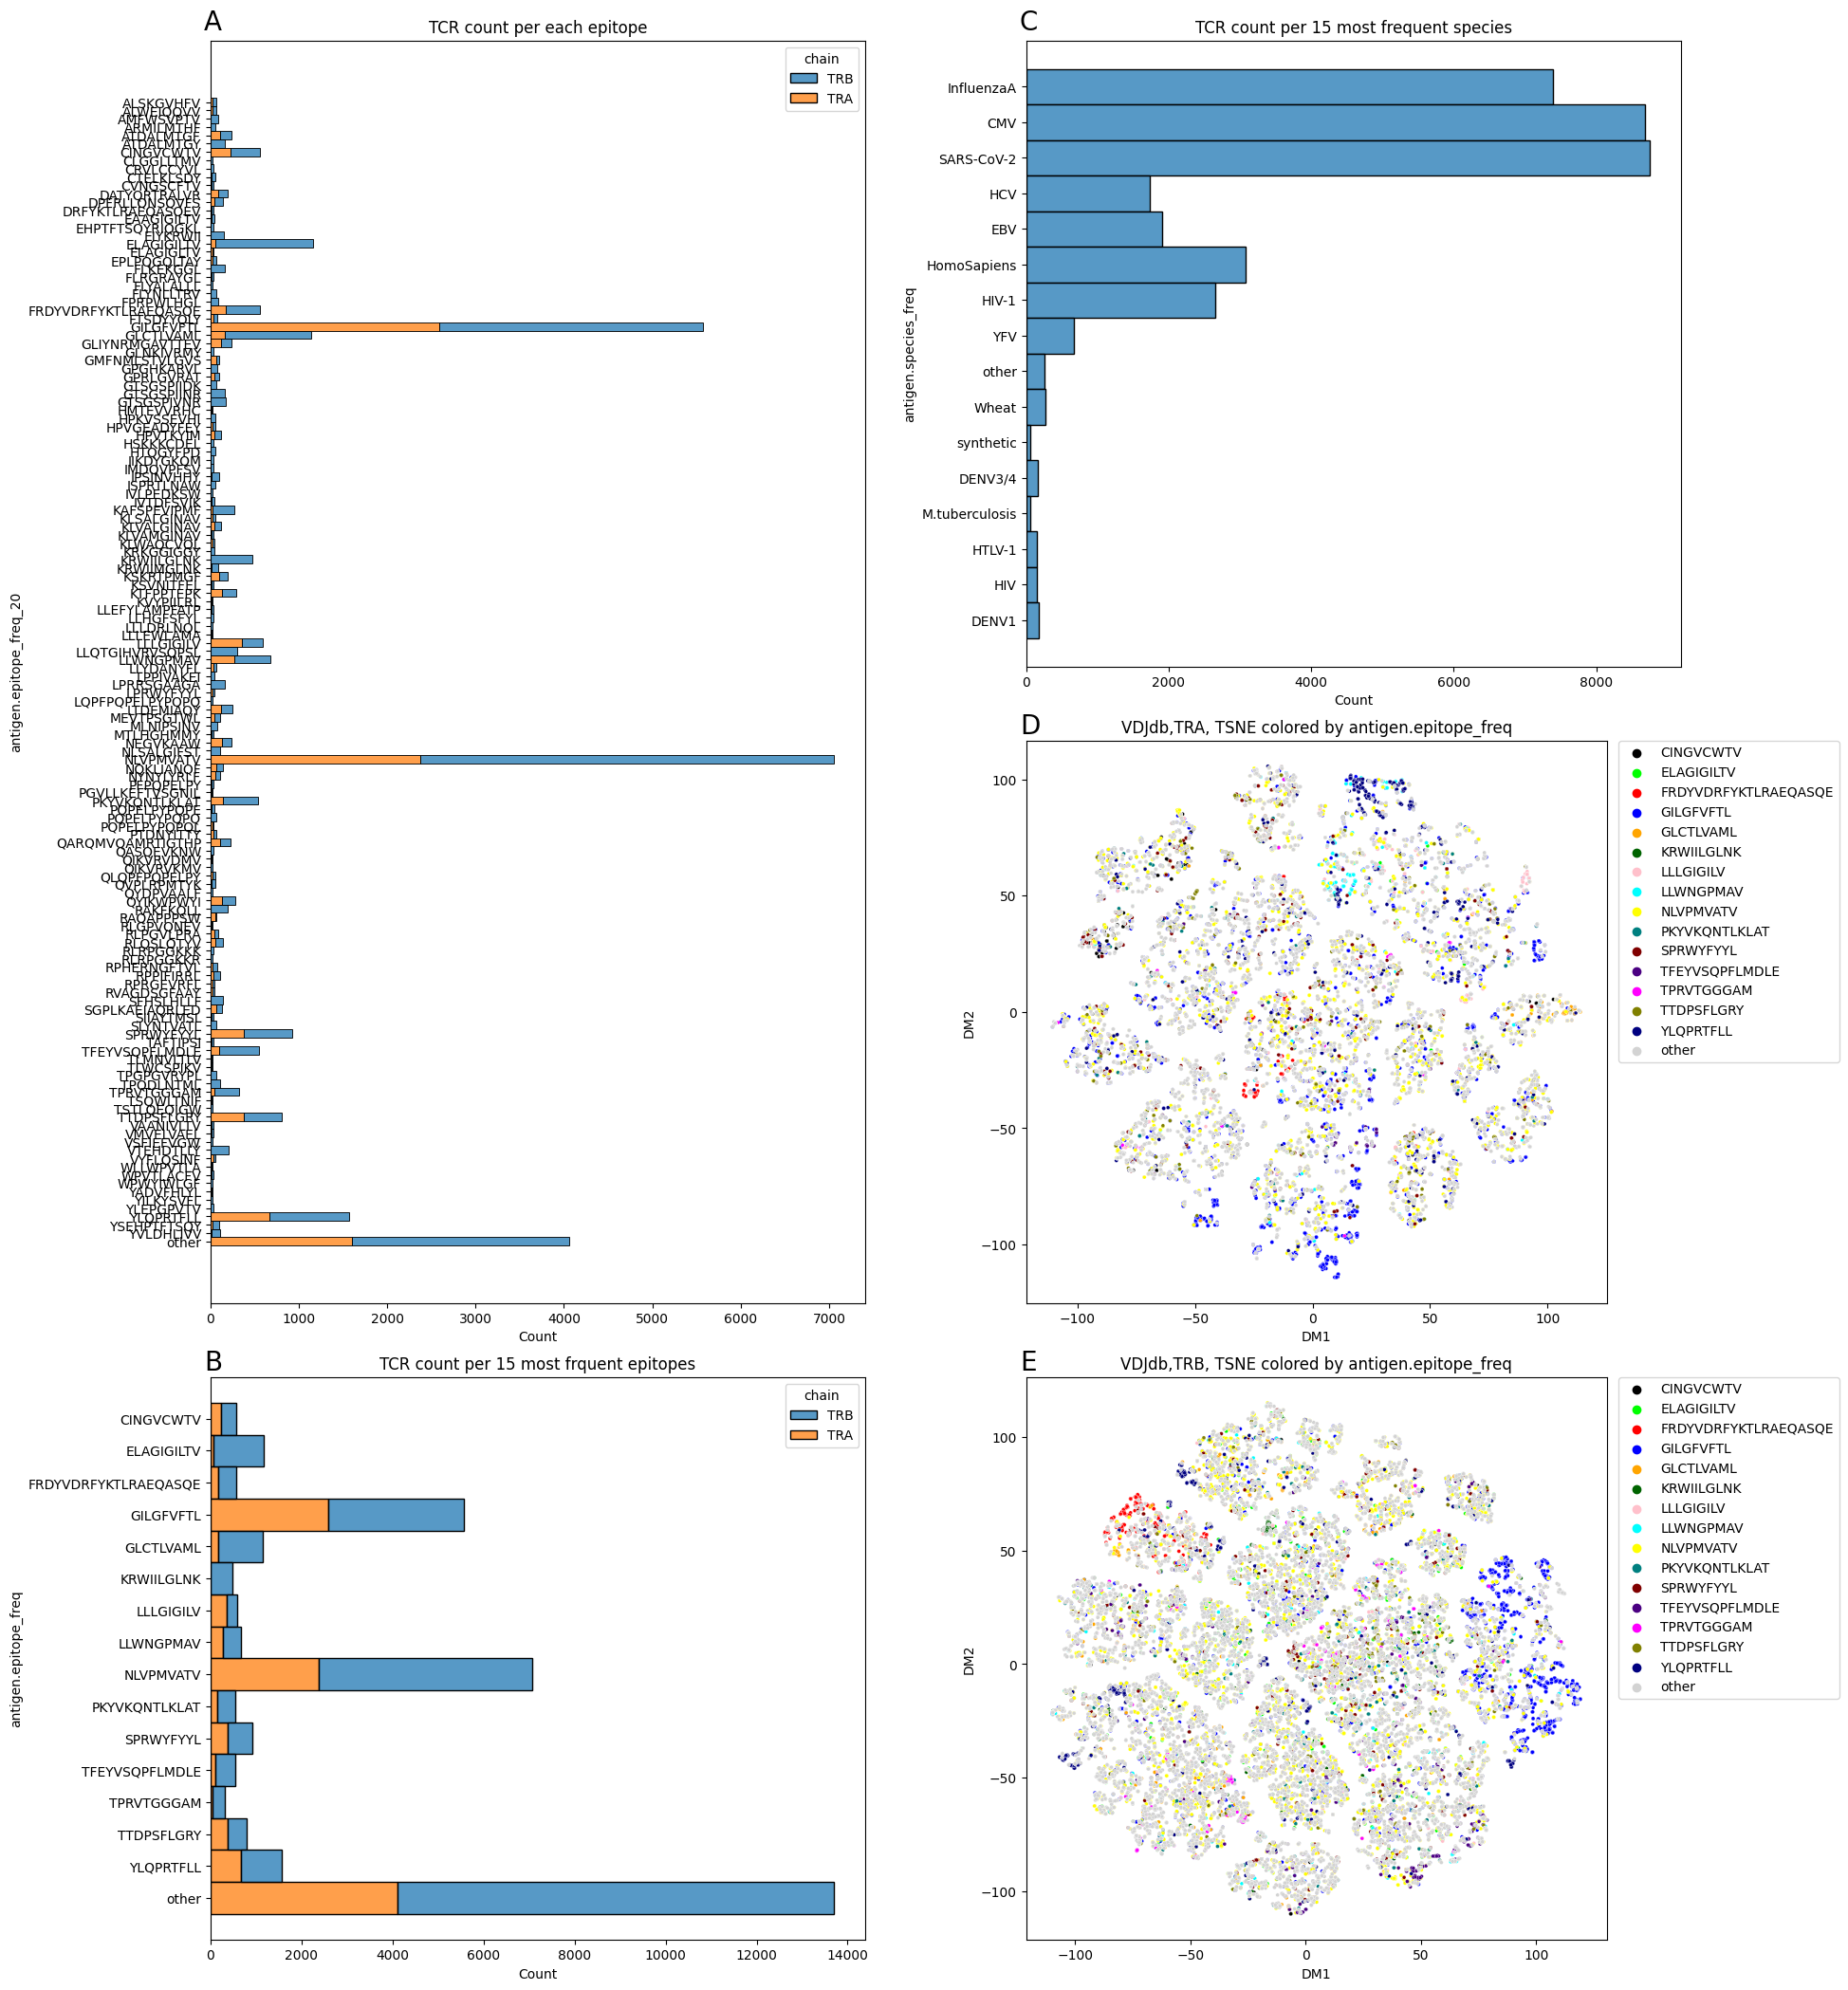

In [24]:

custom_palette = ml_utils.make_custom_palette(label_freq_list)

fig = plt.figure(figsize=(20,26))

delta_x=-0.01
delta_y=1.05
font_size=20


gs00 = fig.add_gridspec(30, 20)

ax1 = fig.add_subplot(gs00[:20, :9])
ax2 = fig.add_subplot(gs00[21:, :9])
ax3 = fig.add_subplot(gs00[:10, 11:])
ax4 = fig.add_subplot(gs00[11:20, 11:19])
ax5 = fig.add_subplot(gs00[21:, 11:19])


sns.histplot(data = data_preped.sort_values(str(label+'_freq_20')), y = str(label+'_freq_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.025, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('TCR count per each epitope')

sns.histplot(data = data_preped.sort_values(str(label+'_freq')), y = str(label+'_freq'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('TCR count per 15 most frquent epitopes')


ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
sns.histplot(y=data_preped[label_high_s],ax=ax3)
ax3.set_title('TCR count per 15 most frequent species')

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}',custom_palette=custom_palette, ax=ax4)
#ax4.set_title('TCR count per 15 most frequent species')

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}',custom_palette=custom_palette, ax=ax5)
#ax5.set_title('TCR count per 15 most frequent species')


#plt.savefig("results/figures/fig2.png")
plt.show()





## Clustering

### eps by knnn

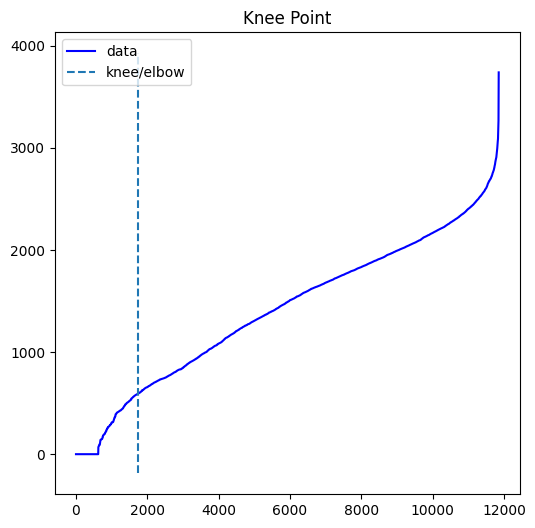

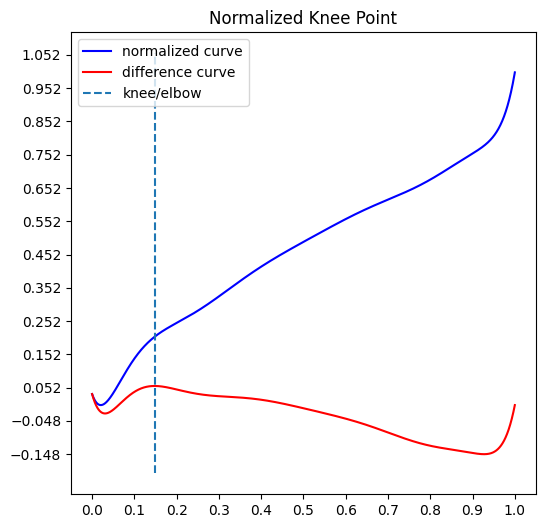

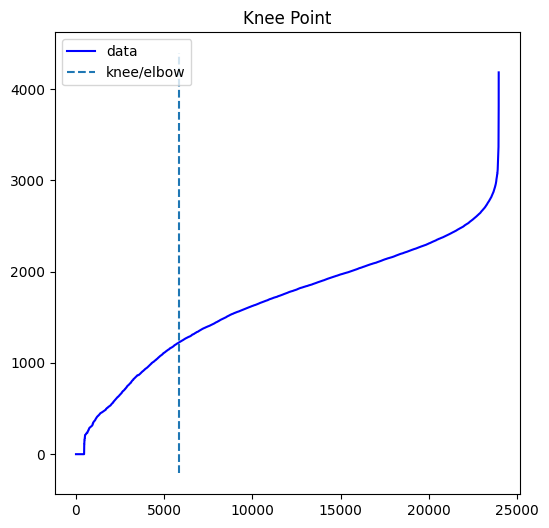

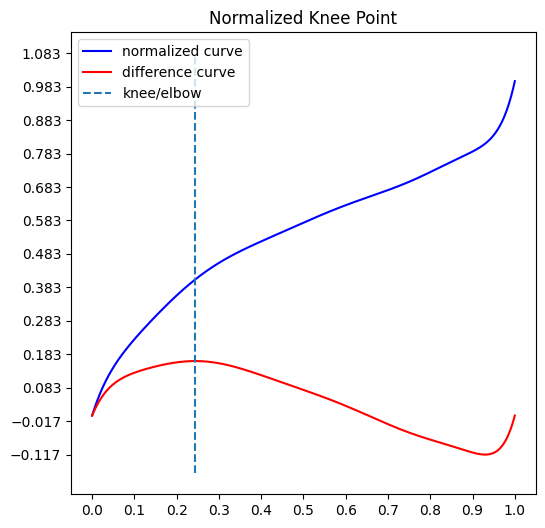

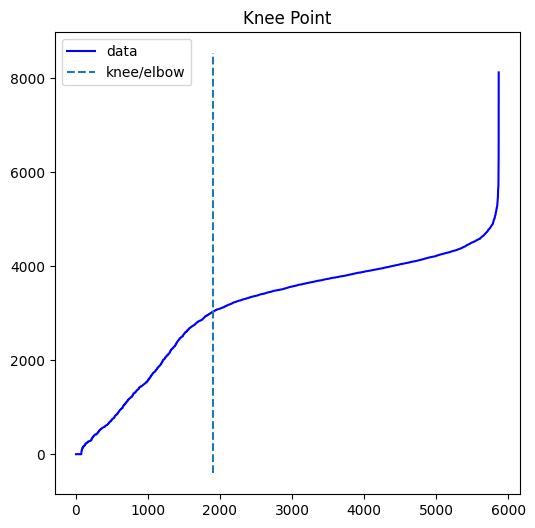

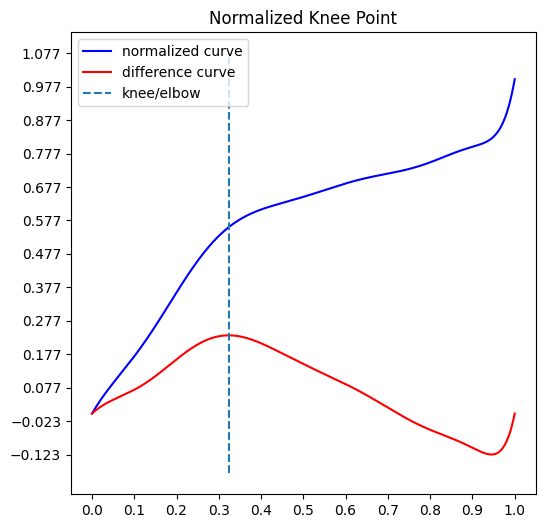

In [14]:
eps_by_knee_dict = {}
for c in ['TRA','TRB','TRA_TRB']:
    chain=c
    eps_by_knee_dict[c]={}
    
    neighbors = 4
#    if chain =='TRA_TRB':
#        nbrs = NearestNeighbors(n_neighbors=neighbors).fit(tcremb.dists[chain]['joined'].drop(tcremb.clonotype_id,axis=1))
#        distances, indices = nbrs.kneighbors(tcremb.dists[chain]['joined'].drop(tcremb.clonotype_id,axis=1))
#    else:
#        nbrs = NearestNeighbors(n_neighbors=neighbors).fit(tcremb.dists[chain].drop(tcremb.clonotype_id,axis=1))
#        distances, indices = nbrs.kneighbors(tcremb.dists[chain].drop(tcremb.clonotype_id,axis=1))
#    distances = np.sort(distances, axis=0)
#    distances = distances[:,1]
    
#    eps_by_knee_dict[c]['max_raw_dist']=round(max(distances),2)
    
    
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(tcremb.pca_clones[chain].drop(tcremb.clonotype_id,axis=1))
    distances, indices = nbrs.kneighbors(tcremb.pca_clones[chain].drop(tcremb.clonotype_id,axis=1))
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    eps_by_knee_dict[c]['max_pca_dist']=round(max(distances),2)
    eps_by_knee_dict[c]['clonotypes_count'] = str(len(tcremb.pca_clones[chain]))

    kneedle = KneeLocator(range(1,len(distances)+1),  #x values
                            distances, # y values
                            S=1.0, #parameter suggested from paper
                            #curve="convex", #parameter from figure
                            curve="concave",
                            interp_method="polynomial",
                            #interp_method="polynomial",        
                          polynomial_degree=10,
                            online = True,
                            direction="increasing", ) #parameter from figure
    
    eps_by_knee_dict[c]['knee']=str(round(distances[kneedle.knee],2))
    kneedle.plot_knee()
    kneedle.plot_knee_normalized()

In [15]:
pd.DataFrame(eps_by_knee_dict)

TRA      TRB  TRA_TRB
max_pca_dist      3739.97  4183.95   8124.9
clonotypes_count    11850    23948     5870
knee               594.26  1225.69  3029.62

### DBSCAN

In [16]:
run_name

'vdjdb_paired'

In [17]:
method= run_name + '_DBSCAN'
dbscan = TCRemb.TCRemb_clustering('DBSCAN')
metrics_dbscan = {}

In [18]:
metrics_dbscan[label]={}

In [19]:
from sklearn.cluster import DBSCAN

In [20]:
chain='TRA'
#coef = 0.85
#model = DBSCAN(eps=round(float(eps_by_knee_dict[chain]['knee'])*coef,2), min_samples=2)
dbscan.clstr(chain,tcremb, label)

purity:0.8477429227237949


In [21]:
df = tcremb.annot_input[chain].merge(dbscan.clstr_labels[chain], how='left')
df['is_cluster'] = df['is_cluster'].fillna(0)
metrics_dbscan[label][chain] = metrics.get_clustermetrics(df, label)
metrics_dbscan[label][chain]['total pairs TCR-epitope'] = len(tcremb.annot[chain])
metrics_dbscan[label][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label][chain]['total unique epitopes'] = str(len(tcremb.annot[chain].drop_duplicates(label)))
metrics_dbscan[label][chain]['label']=label
metrics_dbscan[label][chain]


{'purity': 0.85,
 'retention': 0.11,
 'consistency': 0.0016,
 'ami': 0.76,
 'precision': 0.83,
 'recall': 0.85,
 'f1-score': 0.84,
 'mean_clustsize': 2.69,
 'total pairs TCR-epitope': 11850,
 'total unique TCRs': '11850',
 'total unique epitopes': '797',
 'label': 'antigen.epitope'}

In [22]:
chain='TRB'
#model = DBSCAN(eps=round(float(eps_by_knee_dict[chain]['knee'])*coef,2), min_samples=2)
dbscan.clstr(chain,tcremb, label)

purity:0.8855061150143118


In [23]:
df = tcremb.annot_input[chain].merge(dbscan.clstr_labels[chain], how='left')
df['is_cluster'] = df['is_cluster'].fillna(0)
metrics_dbscan[label][chain] = metrics.get_clustermetrics(df, label)
metrics_dbscan[label][chain]['total pairs TCR-epitope'] = len(tcremb.annot[chain])
metrics_dbscan[label][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label][chain]['total unique epitopes'] = str(len(tcremb.annot[chain].drop_duplicates(label)))
metrics_dbscan[label][chain]['label']=label
metrics_dbscan[label][chain]


{'purity': 0.89,
 'retention': 0.16,
 'consistency': 0.0009,
 'ami': 0.83,
 'precision': 0.88,
 'recall': 0.89,
 'f1-score': 0.88,
 'mean_clustsize': 3.37,
 'total pairs TCR-epitope': 23948,
 'total unique TCRs': '23948',
 'total unique epitopes': '999',
 'label': 'antigen.epitope'}

In [24]:
chain='TRA_TRB'

dbscan.clstr(chain,tcremb, label)

purity:0.9536730641958967


In [25]:
df = tcremb.annot_input[chain].merge(dbscan.clstr_labels[chain], how='left')
df['is_cluster'] = df['is_cluster'].fillna(0)
metrics_dbscan[label][chain] = metrics.get_clustermetrics(df, label)
metrics_dbscan[label][chain]['total pairs TCR-epitope'] = len(tcremb.annot[chain])
metrics_dbscan[label][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label][chain]['total unique epitopes'] = str(len(tcremb.annot[chain].drop_duplicates(label)))
metrics_dbscan[label][chain]['label']=label
metrics_dbscan[label][chain]


{'purity': 0.95,
 'retention': 0.26,
 'consistency': 0.0053,
 'ami': 0.93,
 'precision': 0.95,
 'recall': 0.95,
 'f1-score': 0.95,
 'mean_clustsize': 5.23,
 'total pairs TCR-epitope': 5870,
 'total unique TCRs': '5870',
 'total unique epitopes': '744',
 'label': 'antigen.epitope'}

In [26]:
pd.DataFrame(metrics_dbscan[label])

TRA              TRB          TRA_TRB
purity                              0.85             0.89             0.95
retention                           0.11             0.16             0.26
consistency                       0.0016           0.0009           0.0053
ami                                 0.76             0.83             0.93
precision                           0.83             0.88             0.95
recall                              0.85             0.89             0.95
f1-score                            0.84             0.88             0.95
mean_clustsize                      2.69             3.37             5.23
total pairs TCR-epitope            11850            23948             5870
total unique TCRs                  11850            23948             5870
total unique epitopes                797              999              744
label                    antigen.epitope  antigen.epitope  antigen.epitope

In [28]:
pd.DataFrame(metrics_dbscan[label]).to_csv(f"results/tables/{method}.csv",index=False)

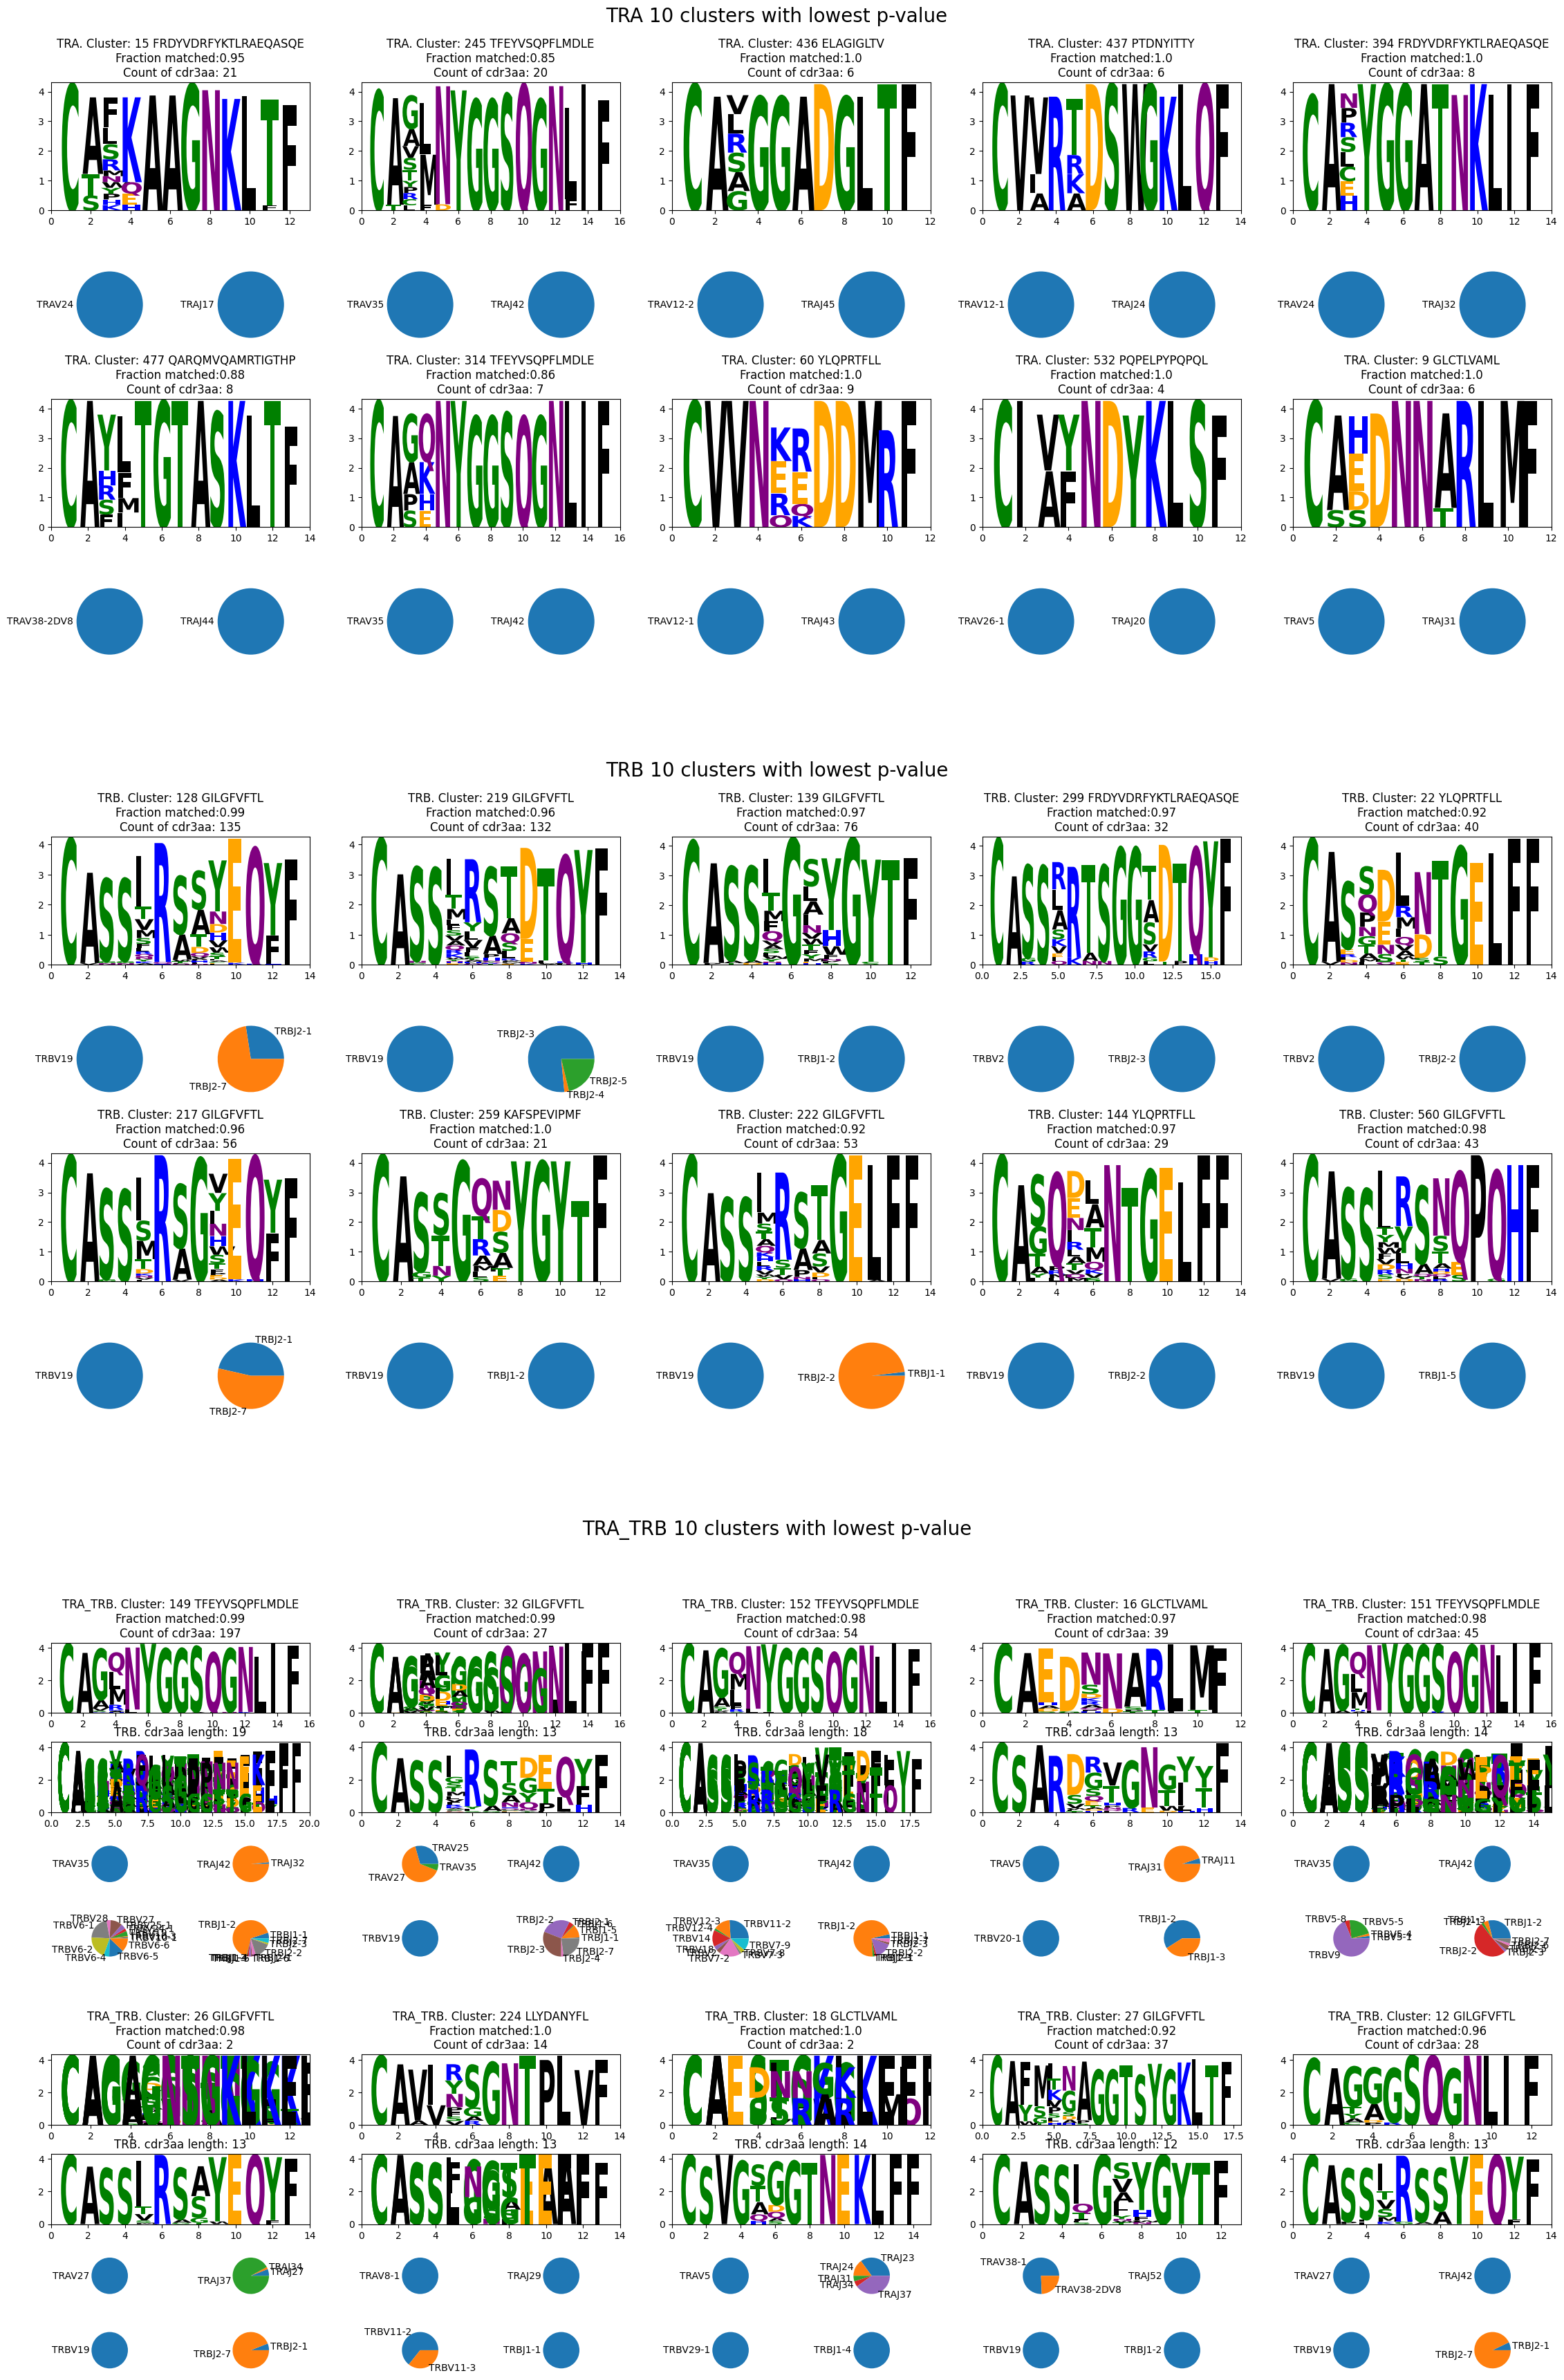

In [38]:
fig = plt.figure(figsize=(28,6*6))
subfigs = fig.subfigures(3, 1,height_ratios=[1,1,1.3])
dbscan.clstrs_motif(tcremb,'TRA', 10, subfigs[0])
subfigs[0].suptitle('TRA 10 clusters with lowest p-value',fontsize=20)
dbscan.clstrs_motif(tcremb, 'TRB', 10, subfigs[1])
subfigs[1].suptitle('TRB 10 clusters with lowest p-value',fontsize=20)
dbscan.clstrs_motif(tcremb, 'TRA_TRB', 10, subfigs[2])
subfigs[2].suptitle('TRA_TRB 10 clusters with lowest p-value',fontsize=20)
#plt.savefig(f"results/figures/vdjdb_dbscan_logo.png",bbox_inches='tight')

if unique_clonotypes:
    plt.savefig(f"results/figures/vdjdb_dbscan_logo_unique_clonotypes.png",bbox_inches='tight')
else:
    plt.savefig(f"results/figures/vdjdb_dbscan_logo.png",bbox_inches='tight')
plt.show()

In [44]:
dbscan.clstr_labels['TRA_TRB'][dbscan.clstr_labels['TRA_TRB']['cluster']==26].drop_duplicates('a_cdr3aa')

cluster  annotId label_cluster  total_cluster  total_group  \
136        26      136     GILGFVFTL             50          663   
180        26      180     GILGFVFTL             50          663   
456        26      456     GILGFVFTL             50          663   
595        26      595     GILGFVFTL             50          663   
600        26      600     GILGFVFTL             50          663   
611        26      611     GILGFVFTL             50          663   
722        26      722     GILGFVFTL             50          663   
725        26      725     GILGFVFTL             50          663   
727        26      727     GILGFVFTL             50          663   
728        26      728     GILGFVFTL             50          663   
729        26      729     GILGFVFTL             50          663   
730        26      730     GILGFVFTL             50          663   
753        26      753     GILGFVFTL             50          663   
977        26      977     GILGFVFTL             50          663   
985        26      985     GILGFVFTL             50          663   
986        26      986     GILGFVFTL             50          663   
987        26      987     GILGFVFTL             50          663   
1748       26     1748     GILGFVFTL             50          663   
1756       26     1756     GILGFVFTL             50          663   
1764       26     1764     GILGFVFTL             50          663   
1778       26     1778     GILGFVFTL             50          663   
1785       26     1785     GILGFVFTL             50          663   
1876       26     1876     GILGFVFTL             50          663   
1899       26     1899     GILGFVFTL             50          663   
1906       26     1906     GILGFVFTL             50          663   
1935       26     1935     GILGFVFTL             50          663   
2103       26     2103     GILGFVFTL             50          663   
2119       26     2119     GILGFVFTL             50          663   
2121       26     2121     GILGFVFTL             50          663   
2122       26     2122     GILGFVFTL             50          663   
2124       26     2124     GILGFVFTL             50          663   
3716       26     3717     GILGFVFTL             50          663   

      count_matched  fraction_matched  fraction_matched_exp       p_value  \
136              49              0.98              0.112947  1.733485e-45   
180              49              0.98              0.112947  1.733485e-45   
456              49              0.98              0.112947  1.733485e-45   
595              49              0.98              0.112947  1.733485e-45   
600              49              0.98              0.112947  1.733485e-45   
611              49              0.98              0.112947  1.733485e-45   
722              49              0.98              0.112947  1.733485e-45   
725              49              0.98              0.112947  1.733485e-45   
727              49              0.98              0.112947  1.733485e-45   
728              49              0.98              0.112947  1.733485e-45   
729              49              0.98              0.112947  1.733485e-45   
730              49              0.98              0.112947  1.733485e-45   
753              49              0.98              0.112947  1.733485e-45   
977              49              0.98              0.112947  1.733485e-45   
985              49              0.98              0.112947  1.733485e-45   
986              49              0.98              0.112947  1.733485e-45   
987              49              0.98              0.112947  1.733485e-45   
1748             49              0.98              0.112947  1.733485e-45   
1756             49              0.98              0.112947  1.733485e-45   
1764             49              0.98              0.112947  1.733485e-45   
1778             49              0.98              0.112947  1.733485e-45   
1785             49              0.98              0.112947  1.7334

In [93]:
dbscan_s = TCRemb.TCRemb_clustering('DBSCAN')

In [94]:
metrics_dbscan[label_s]={}

In [95]:
chain='TRA'
model = DBSCAN(eps=750, min_samples=2)
dbscan_s.clstr(chain,tcremb, label_s, model=model)

purity:0.8828107118333715


In [96]:
df = tcremb.annot[chain].merge(dbscan_s.clstr_labels[chain])
metrics_dbscan[label_s][chain] = metrics.get_clustermetrics(df, label_s)
metrics_dbscan[label_s][chain]['total pairs TCR-specie'] = len(tcremb.annot[chain])
metrics_dbscan[label_s][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label_s][chain]['total unique antigen species'] = str(len(tcremb.annot[chain].drop_duplicates(label_s)))
metrics_dbscan[label_s][chain]['label']=label_s
metrics_dbscan[label_s][chain]

{'purity': 0.8828107118333715,
 'retention': 0.2966,
 'consistency': 0.01,
 'ami': 0.6997,
 'precision': 0.8826,
 'recall': 0.8828,
 'f1-score': 0.8827,
 'mean_clustsize': 5.3607,
 'total pairs TCR-specie': 14730,
 'total unique TCRs': '11850',
 'total unique antigen species': '27',
 'label': 'antigen.species'}

In [97]:
chain='TRB'
model = DBSCAN(eps=750, min_samples=2)
dbscan_s.clstr(chain,tcremb, label_s, model=model)

purity:0.9461856889414547


In [98]:
df = tcremb.annot[chain].merge(dbscan_s.clstr_labels[chain])
metrics_dbscan[label_s][chain] = metrics.get_clustermetrics(df, label_s)
metrics_dbscan[label_s][chain]['total pairs TCR-specie'] = len(tcremb.annot[chain])
metrics_dbscan[label_s][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label_s][chain]['total unique antigen species'] = str(len(tcremb.annot[chain].drop_duplicates(label_s)))
metrics_dbscan[label_s][chain]['label']=label_s
metrics_dbscan[label_s][chain]

{'purity': 0.9461856889414547,
 'retention': 0.1737,
 'consistency': 0.0075,
 'ami': 0.856,
 'precision': 0.9455,
 'recall': 0.9462,
 'f1-score': 0.9458,
 'mean_clustsize': 5.4026,
 'total pairs TCR-specie': 29207,
 'total unique TCRs': '23948',
 'total unique antigen species': '30',
 'label': 'antigen.species'}

In [99]:
chain='TRA_TRB'
model = DBSCAN(eps=750, min_samples=2)
dbscan_s.clstr(chain,tcremb, label_s, model=model)

purity:0.988388969521045


In [100]:
df = tcremb.annot[chain].merge(dbscan_s.clstr_labels[chain])
metrics_dbscan[label_s][chain] = metrics.get_clustermetrics(df, label_s)
metrics_dbscan[label_s][chain]['total pairs TCR-specie'] = len(tcremb.annot[chain])
metrics_dbscan[label_s][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label_s][chain]['total unique antigen species'] = str(len(tcremb.annot[chain].drop_duplicates(label_s)))
metrics_dbscan[label_s][chain]['label']=label_s
metrics_dbscan[label_s][chain]

{'purity': 0.988388969521045,
 'retention': 0.1062,
 'consistency': 0.0154,
 'ami': 0.9647,
 'precision': 0.9857,
 'recall': 0.9884,
 'f1-score': 0.987,
 'mean_clustsize': 4.0769,
 'total pairs TCR-specie': 6490,
 'total unique TCRs': '5870',
 'total unique antigen species': '26',
 'label': 'antigen.species'}

In [85]:
pd.DataFrame(metrics_dbscan[label_s])

TRA       TRB   TRA_TRB
purity                   0.882811  0.946186  0.988389
retention                  0.2966    0.1737    0.1062
consistency                0.0012    0.0015    0.0073
ami                        0.5498    0.6619    0.8194
precision                     0.0       0.0       0.0
recall                        0.0       0.0       0.0
f1-score                        0         0         0
mean_clustsize             5.3607    5.4026    4.0769
total pairs TCR-epitope     14730     29207      6490
total unique TCRs           11850     23948      5870
total unique epitopes         884      1079       818

In [101]:
pd.concat([pd.DataFrame(metrics_dbscan[label]),pd.DataFrame(metrics_dbscan[label_s])],axis=1)

TRA              TRB  \
purity                               0.843214         0.928839   
retention                              0.2966           0.1737   
consistency                            0.0012           0.0015   
ami                                    0.7564           0.8912   
precision                               0.818           0.9236   
recall                                 0.8432           0.9288   
f1-score                               0.8304           0.9262   
mean_clustsize                         5.3607           5.4026   
total pairs TCR-epitope                 14730            29207   
total unique TCRs                       11850            23948   
total unique epitopes                     884             1079   
label                         antigen.epitope  antigen.epitope   
total pairs TCR-specie                    NaN              NaN   
total unique antigen species              NaN              NaN   

                                      TRA_TRB              TRA  \
purity                               0.985486         0.882811   
retention                              0.1062           0.2966   
consistency                            0.0073             0.01   
ami                                    0.9702           0.6997   
precision                              0.9825           0.8826   
recall                                 0.9855           0.8828   
f1-score                                0.984           0.8827   
mean_clustsize                         4.0769           5.3607   
total pairs TCR-epitope                  6490              NaN   
total unique TCRs                        5870            11850   
total unique epitopes                     818              NaN   
label                         antigen.epitope  antigen.species   
total pairs TCR-specie                    NaN            14730   
total unique antigen species              NaN               27   

                                          TRB          TRA_TRB  
purity                               0.946186         0.988389  
retention                              0.1737           0.1062  
consistency                            0.0075           0.0154  
ami                                     0.856           0.9647  
precision                              0.9455           0.9857  
recall                                 0.9462           0.9884  
f1-score                               0.9458            0.987  
mean_clustsize                         5.4026           4.0769  
total pairs TCR-epitope                   NaN              NaN  
total unique TCRs                       23948             5870  
total unique epitopes                     NaN              NaN  
label                         antigen.species  antigen.species  
total pairs TCR-specie                  29207             6490  
total unique antigen species               30               26

In [ ]:
metrcs_res = pd.DataFrame(metrics_dbscan)
metrcs_res

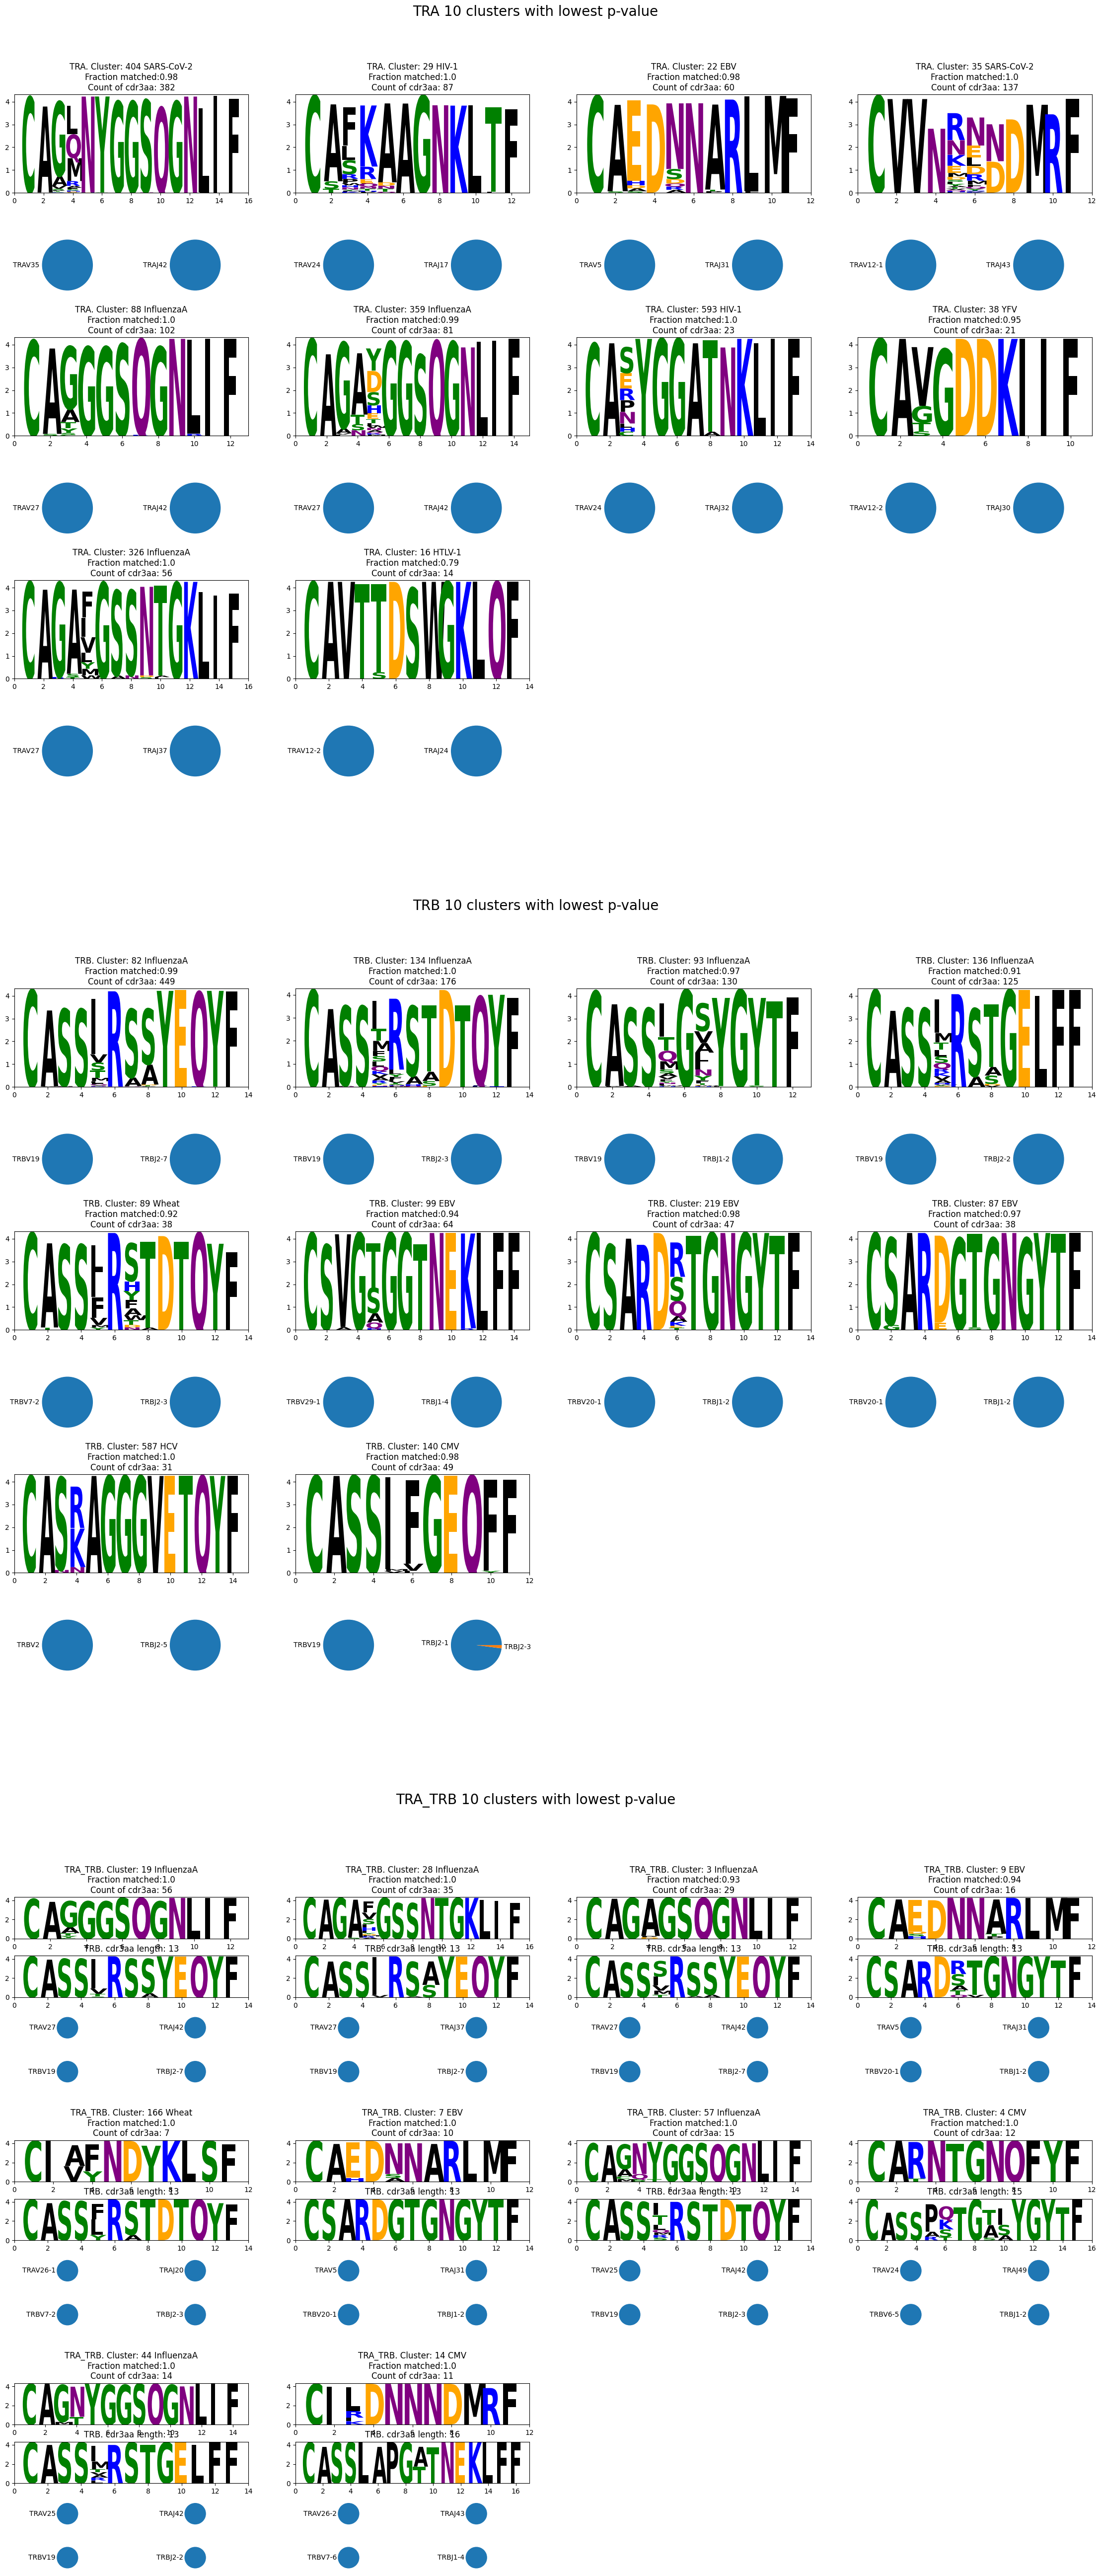

In [102]:
fig = plt.figure(figsize=(28,6*9))
subfigs = fig.subfigures(3, 1)
dbscan_s.clstrs_motif(tcremb,'TRA', 10, subfigs[0])
subfigs[0].suptitle('TRA 10 clusters with lowest p-value',fontsize=20)
dbscan_s.clstrs_motif(tcremb, 'TRB', 10, subfigs[1])
subfigs[1].suptitle('TRB 10 clusters with lowest p-value',fontsize=20)
dbscan_s.clstrs_motif(tcremb, 'TRA_TRB', 10, subfigs[2])
subfigs[2].suptitle('TRA_TRB 10 clusters with lowest p-value',fontsize=20)
plt.savefig(f"results/figures/fig3_dbscan_s.png")

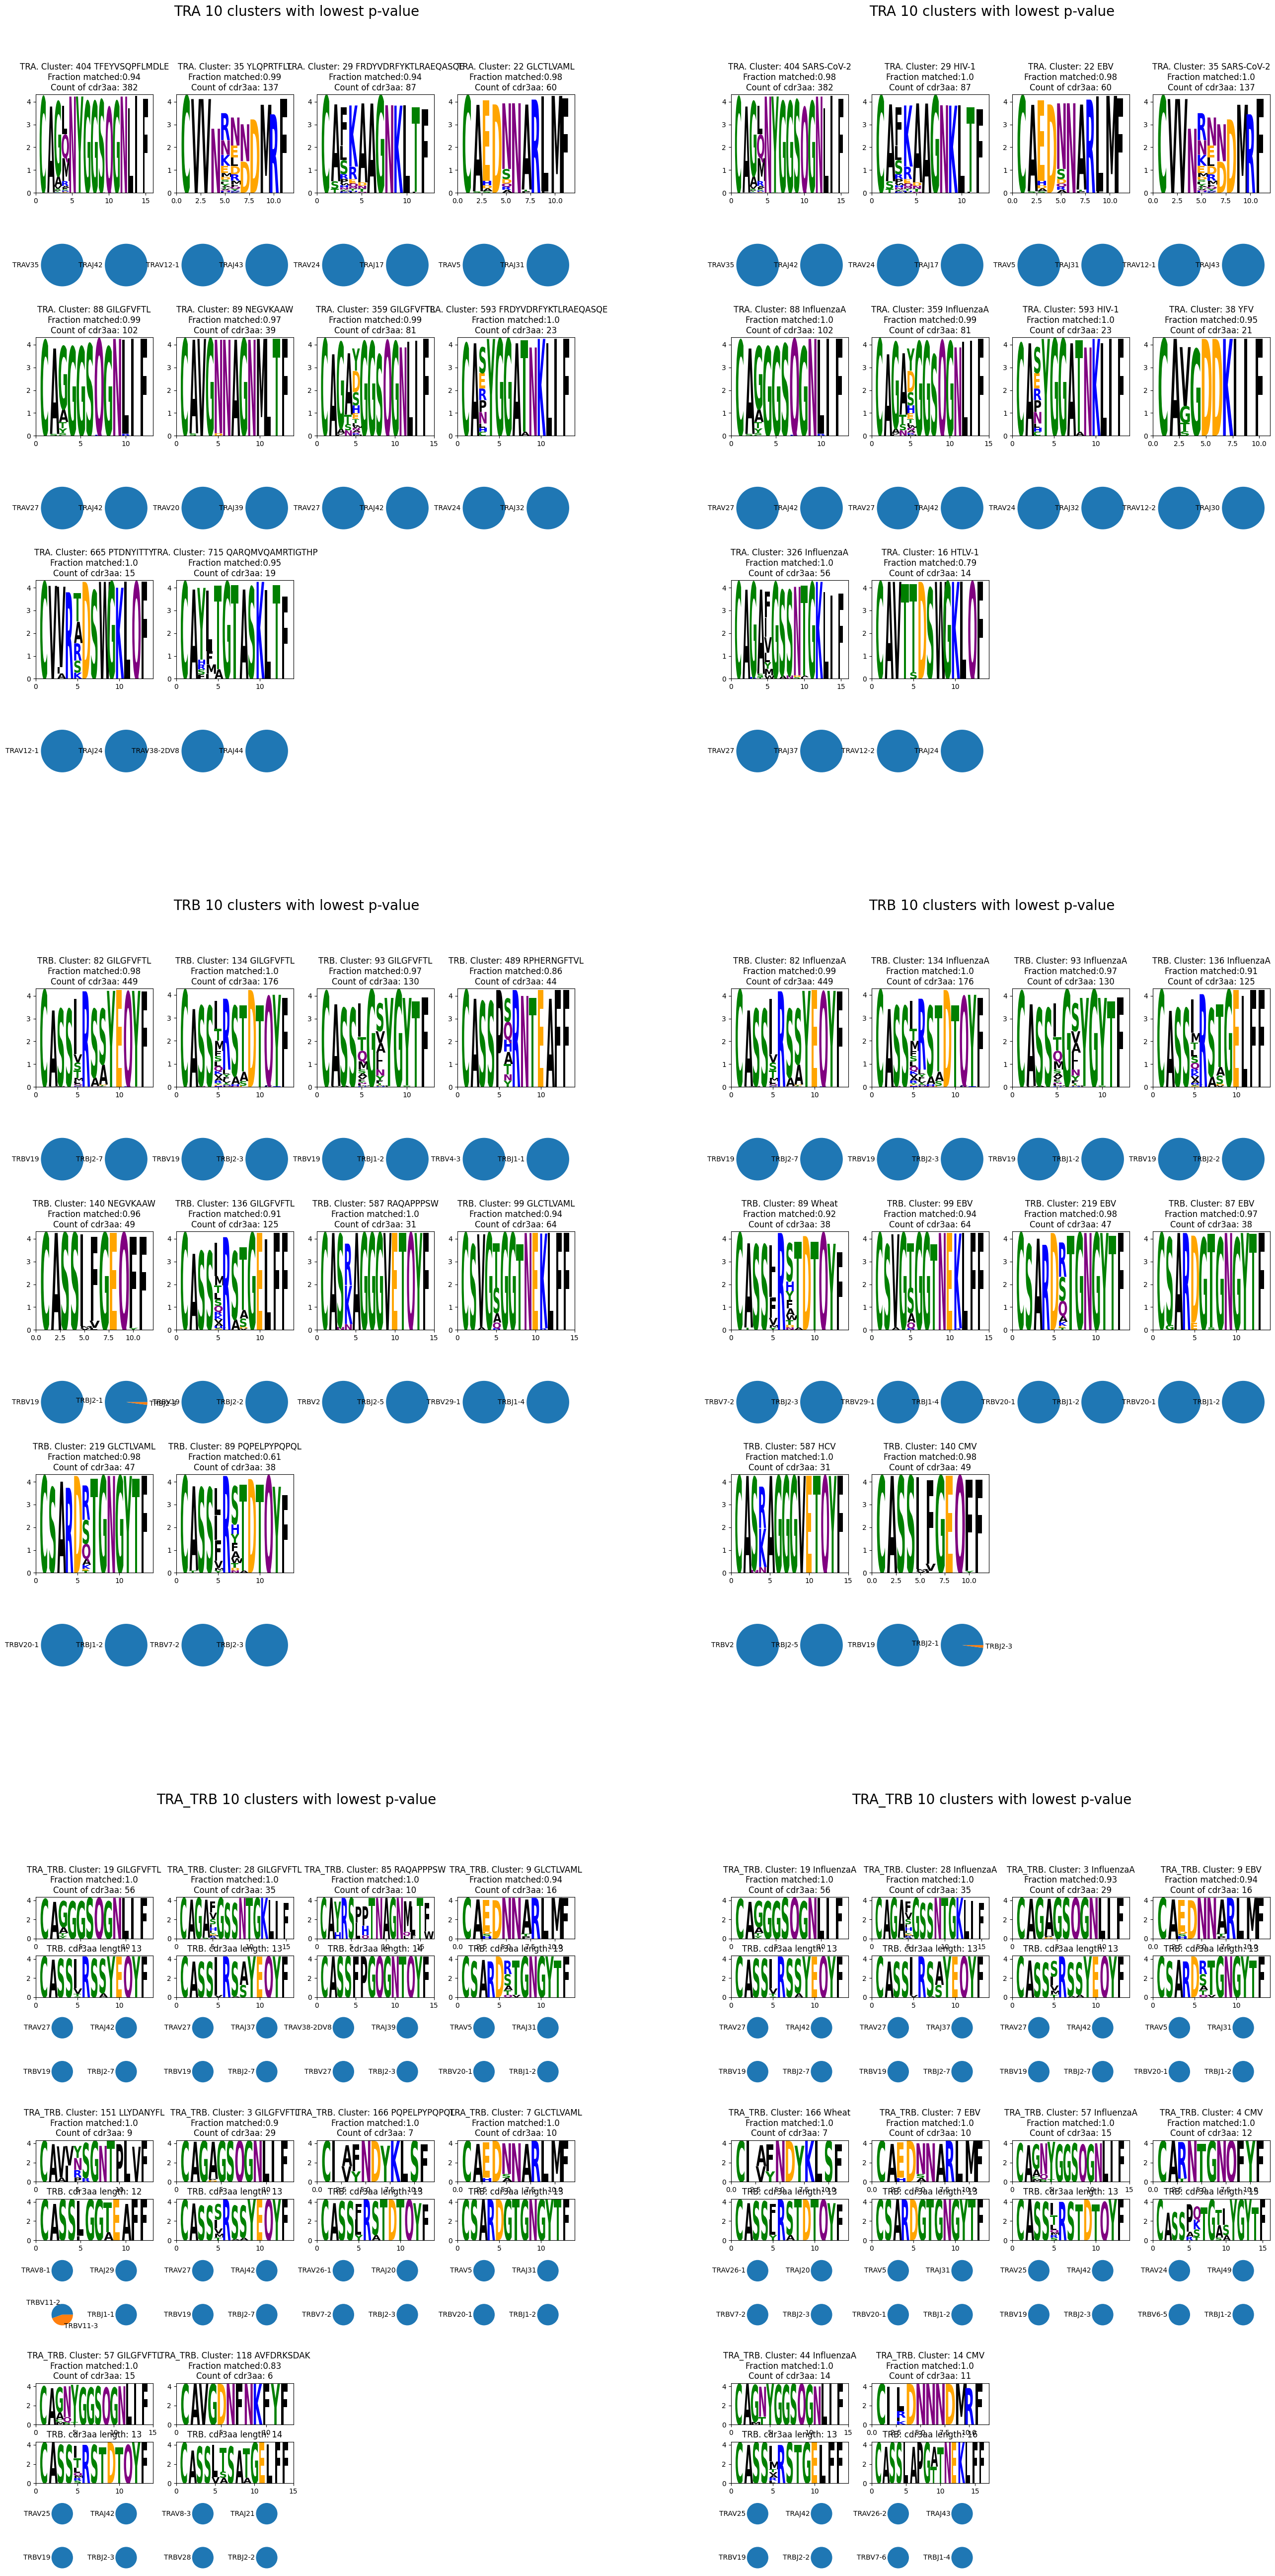

In [110]:
fig = plt.figure(figsize=(7*4,6*9))
subfigs = fig.subfigures(3, 2)

dbscan.clstrs_motif(tcremb,'TRA', 10, subfigs[0,0])
subfigs[0,0].suptitle('TRA 10 clusters with lowest p-value',fontsize=20)
dbscan.clstrs_motif(tcremb, 'TRB', 10, subfigs[1,0])
subfigs[1,0].suptitle('TRB 10 clusters with lowest p-value',fontsize=20)
dbscan.clstrs_motif(tcremb, 'TRA_TRB', 10, subfigs[2,0])
subfigs[2,0].suptitle('TRA_TRB 10 clusters with lowest p-value',fontsize=20)


dbscan_s.clstrs_motif(tcremb,'TRA', 10, subfigs[0,1])
subfigs[0,1].suptitle('TRA 10 clusters with lowest p-value',fontsize=20)
dbscan_s.clstrs_motif(tcremb, 'TRB', 10, subfigs[1,1])
subfigs[1,1].suptitle('TRB 10 clusters with lowest p-value',fontsize=20)
dbscan_s.clstrs_motif(tcremb, 'TRA_TRB', 10, subfigs[2,1])
subfigs[2,1].suptitle('TRA_TRB 10 clusters with lowest p-value',fontsize=20)

plt.savefig(f"results/figures/fig_sup_dbscan_epi_s.png")

In [29]:
import tcremb.motif_logo as motif_logo
import matplotlib.gridspec as gridspec
def clstrs_motif(kmeans,data, chain, n_head_clstrs, sfig=None):
    if (chain=='TRA') or (chain=='TRB'):
        plt_clusters = list(kmeans.binom_res[chain].sort_values('p_value').head(n_head_clstrs)['cluster'])
        clstr_data = pd.merge(kmeans.clstr_labels[chain],data.annot[chain])
    
        clstr_data['cdr3aa_len'] = clstr_data['cdr3aa'].apply(len)
        
        #n_rows = math.ceil(len(plt_clusters)/4) +1
        n_rows = math.ceil(len(plt_clusters)/4)
        if sfig is None:
            sfig = plt.figure(figsize=(28,7*n_rows))
            outer_grid = gridspec.GridSpec(n_rows, 4,figure=sfig)        
        else:
            outer_grid = gridspec.GridSpec(n_rows, 4,figure=sfig)
        
        gs = []
        ax_list = []
        for i in range(len(plt_clusters)):
            cl_row = math.ceil((i+1)/4)-1
            cl_col = i%4
            gs.append(outer_grid[cl_row,cl_col].subgridspec(6, 2))
            ax_list.append([sfig.add_subplot(gs[i][:3, :2])
                            ,sfig.add_subplot(gs[i][4:6, 0])
                            ,sfig.add_subplot(gs[i][4:6, 1])])
    
            plot_logo(clstr_data, chain, plt_clusters[i], ax_list[i])

    elif chain=='TRA_TRB':
        plt_clusters = list(data.binom_res[chain].sort_values('p_value').head(n_head_clstrs)['cluster'])
        clstr_data = pd.merge(data.clstr_labels[chain],data.annot[chain])
        
        clstr_data['a_cdr3aa_len'] = clstr_data['a_cdr3aa'].apply(len)
        clstr_data['b_cdr3aa_len'] = clstr_data['b_cdr3aa'].apply(len)
    
        #n_rows = math.ceil(len(plt_clusters)/4) +1
        n_rows = math.ceil(len(plt_clusters)/4)
        
        if sfig is None:
            sfig = plt.figure(figsize=(28,8*n_rows))
            outer_grid = gridspec.GridSpec(n_rows, 4,figure=sfig)        
        else:
            outer_grid = gridspec.GridSpec(n_rows, 4,figure=sfig)
        
        outer_grid = gridspec.GridSpec(n_rows, 4,figure=fig)
        gs = []
        ax_list = []
        for i in range(len(plt_clusters)):
            cl_row = math.ceil((i+1)/4)-1
            cl_col = i%4
            gs.append(outer_grid[cl_row,cl_col].subgridspec(14, 2))
            ax_list.append([sfig.add_subplot(gs[i][1:4, :2])
                            ,sfig.add_subplot(gs[i][5:8, :2])
                            ,sfig.add_subplot(gs[i][9:11, 0])
                            ,sfig.add_subplot(gs[i][9:11, 1])
                            ,sfig.add_subplot(gs[i][12:14, 0])
                            ,sfig.add_subplot(gs[i][12:14, 1])])
    
            self.__plot_logo_paired(clstr_data, chain, plt_clusters[i], ax_list[i])
    else:
        print('chain is incorrect')
        
        
def plot_logo(clstr_data, chain, c, list_ax):
        
    cluster_df = clstr_data[clstr_data['cluster']==c]
    lengs = cluster_df['cdr3aa_len'].drop_duplicates()
    fr_matched = cluster_df['fraction_matched'].drop_duplicates().reset_index(drop=True)[0]
    epi = cluster_df['label_cluster'].drop_duplicates().reset_index(drop=True)[0]
    total_cl = cluster_df['total_cluster'].drop_duplicates().reset_index(drop=True)[0]
    alphabet = [aa for aa in 'ARNDCQEGHILKMFPSTWYVBZX-']
    for l in lengs:
        seqs = cluster_df[cluster_df['cdr3aa_len']==l]['cdr3aa'].reset_index(drop=True)
        if len(seqs) > 4:
            motif_logo.plot_amino_logo(seqs, 'title',ax = list_ax[0])
            list_ax[0].set_title(f"{chain}. Cluster: {c} {epi}\nFraction matched:{round(fr_matched,2)}\nCount of cdr3aa: {len(seqs)}")
    plot_v_j = clstr_data[clstr_data['cluster']==c]

        
    plot_v_j = pd.DataFrame(plot_v_j.groupby('v')['cdr3aa'].count().reset_index())
    list_ax[1].pie(plot_v_j['cdr3aa'],labels=plot_v_j['v'])


    plot_v_j = clstr_data[clstr_data['cluster']==c]
    plot_v_j = pd.DataFrame(plot_v_j.groupby('j')['cdr3aa'].count().reset_index())
    list_ax[2].pie(plot_v_j['cdr3aa'],labels=plot_v_j['j'])   

## classification

### RF

In [17]:
clf = TCRemb.TCRemb_clf('RF_freq')
#clf_100 = TCRemb.TCRemb_clf('RF_freq')

In [18]:

chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb, label_high, model=model,test_size=0.15)

Train accuracy: 0.9904686258935663
Test accuracy: 0.45556805399325084
macro: {'f1': 0.31781814397374974, 'precision': 0.2663000633526532, 'recall': 0.5064302307347868}
weighted: {'f1': 0.48645227530216684, 'precision': 0.6002063159550638, 'recall': 0.45556805399325084}


In [19]:
chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb, label_high, model, test_size=0.15)

Train accuracy: 0.9751903709162368
Test accuracy: 0.4954077372669079
macro: {'f1': 0.27056803011677166, 'precision': 0.22708934687916466, 'recall': 0.6589715291859723}
weighted: {'f1': 0.5684472937379411, 'precision': 0.8121906183145472, 'recall': 0.4954077372669079}


In [20]:
chain='TRA_TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb, label_high, model, test_size=0.15)

Train accuracy: 0.9837642814191221
Test accuracy: 0.5527809307604994
macro: {'f1': 0.17310610245884692, 'precision': 0.15732614833731978, 'recall': 0.4691079107228176}
weighted: {'f1': 0.6683178427124942, 'precision': 0.9083265417928306, 'recall': 0.5527809307604994}


accuracy: 0.46
f1_weighted:0.49
precision:0.6
recall:0.46
accuracy: 0.5
f1_weighted:0.57
precision:0.81
recall:0.5
accuracy: 0.55
f1_weighted:0.67
precision:0.91
recall:0.55


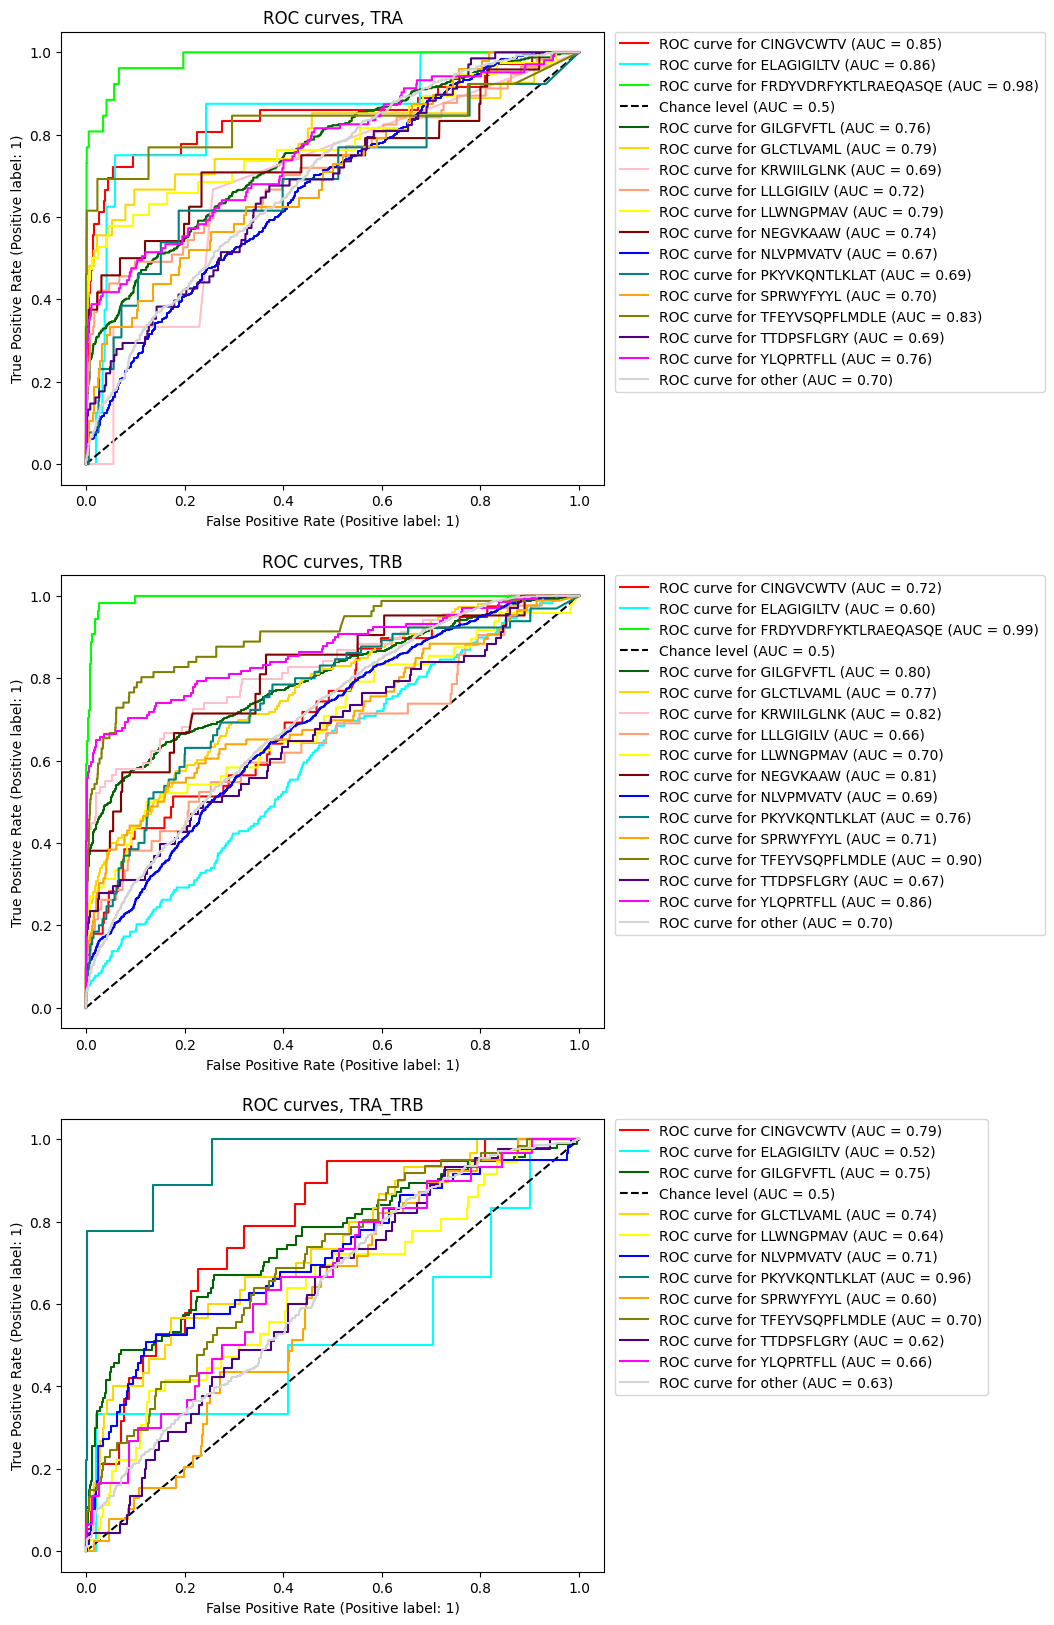

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(7,20))
clf.roc_auc('TRA',custom_palette=custom_palette, ax=axs[0])
clf.roc_auc('TRB',custom_palette=custom_palette, ax=axs[1])
clf.roc_auc('TRA_TRB',custom_palette=custom_palette, ax=axs[2])
#plt.savefig("results/figures/vdjdb_rf.png",bbox_inches='tight')

if unique_clonotypes:
    plt.savefig("results/figures/vdjdb_rf_unique_clonotypes.png",bbox_inches='tight')
else:
    plt.savefig("results/figures/vdjdb_rf_tsne.png",bbox_inches='tight')

accuracy: 0.63
f1_weighted:0.66
precision:0.82
recall:0.63


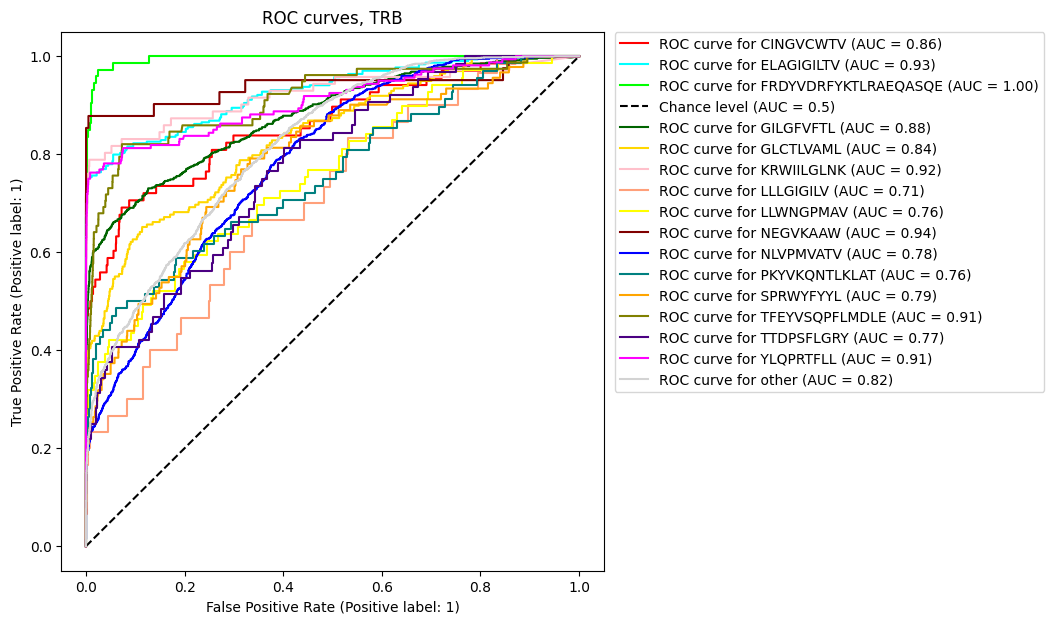

In [20]:
clf.roc_auc('TRB',custom_palette=custom_palette)

accuracy: 0.61
f1_weighted:0.68
precision:0.86
recall:0.61


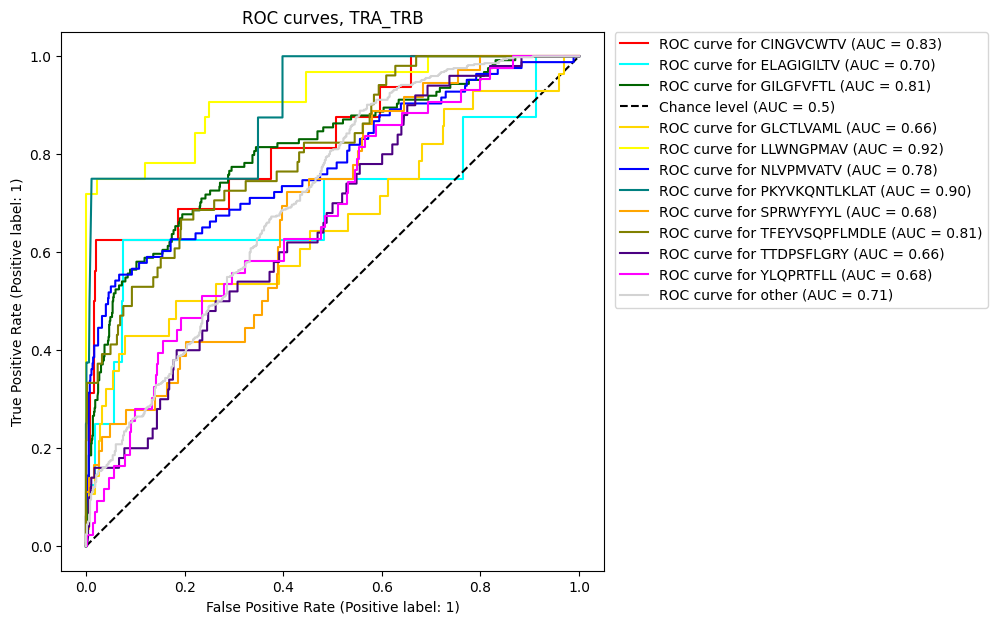

In [21]:
clf.roc_auc('TRA_TRB',custom_palette=custom_palette)

In [35]:

chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_100.clf(chain,tcremb_100, label_high, model=model,test_size=0.15)

Train accuracy: 0.9737047898338221
Test accuracy: 0.46234772978959027
macro: {'f1': 0.35935283832233667, 'precision': 0.3122602049306057, 'recall': 0.4997767584648407}
weighted: {'f1': 0.4935309266784134, 'precision': 0.6058821359435311, 'recall': 0.46234772978959027}


In [36]:

chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_100.clf(chain,tcremb_100, label_high, model=model,test_size=0.15)

Train accuracy: 0.9661091334666212
Test accuracy: 0.5138121546961326
macro: {'f1': 0.2899020902090774, 'precision': 0.24013216442287563, 'recall': 0.7025952104289664}
weighted: {'f1': 0.5851219893957911, 'precision': 0.7959271234075305, 'recall': 0.5138121546961326}


accuracy: 0.45
f1_weighted:0.49
precision:0.63
recall:0.45


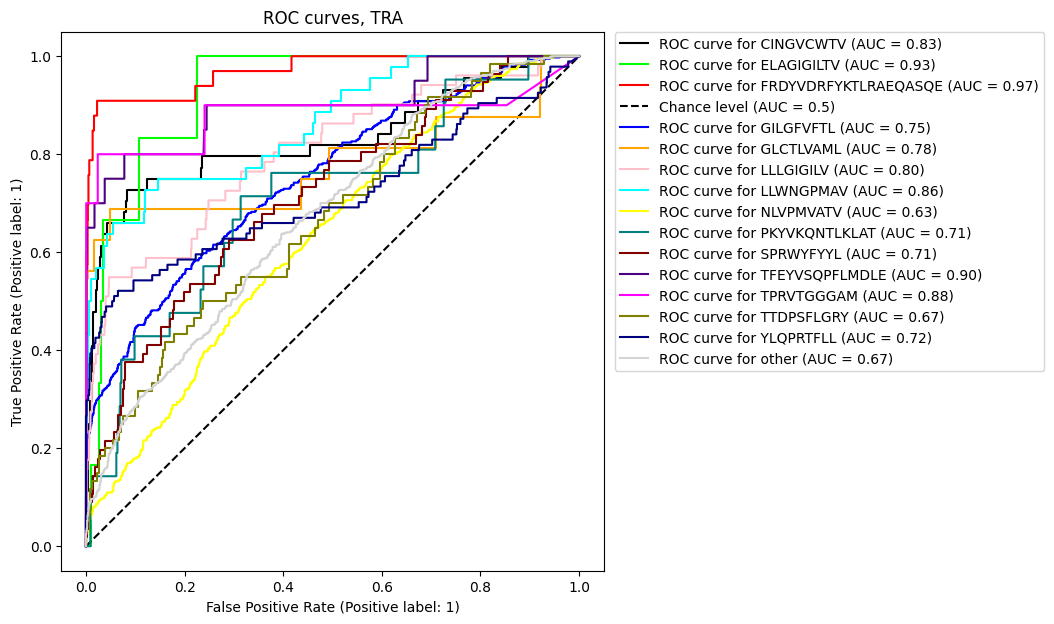

In [37]:
clf.roc_auc('TRA',custom_palette=custom_palette)

accuracy: 0.46
f1_weighted:0.49
precision:0.61
recall:0.46


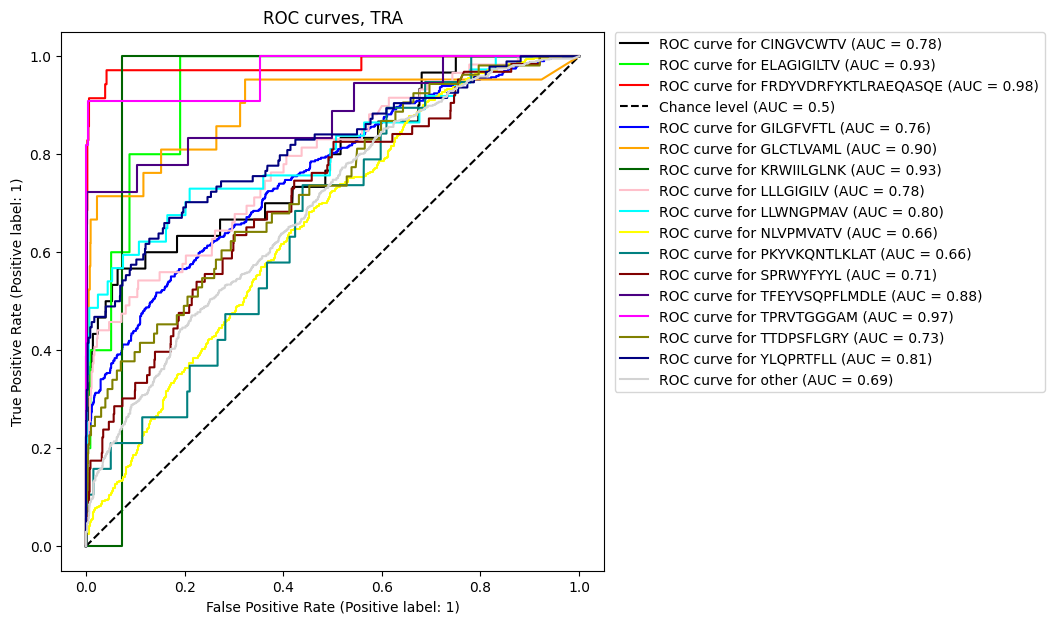

In [38]:
clf_100.roc_auc('TRA',custom_palette=custom_palette)

In [24]:
clf.roc_auc_proba_df['TRA'].sort_values('class')

class   roc_auc
0              CINGVCWTV  0.788259
1             ELAGIGILTV  0.849968
2   FRDYVDRFYKTLRAEQASQE  0.980556
3              GILGFVFTL  0.722378
4              GLCTLVAML  0.821572
5             KRWIILGLNK       NaN
6              LLLGIGILV  0.825648
7              LLWNGPMAV  0.771896
8              NLVPMVATV  0.633029
9          PKYVKQNTLKLAT  0.598260
10             SPRWYFYYL  0.671436
11        TFEYVSQPFLMDLE  0.793717
12            TPRVTGGGAM  0.811483
13            TTDPSFLGRY  0.720360
14             YLQPRTFLL  0.698033
15                 other  0.668636

accuracy: 0.5
f1_weighted:0.58
precision:0.8
recall:0.5


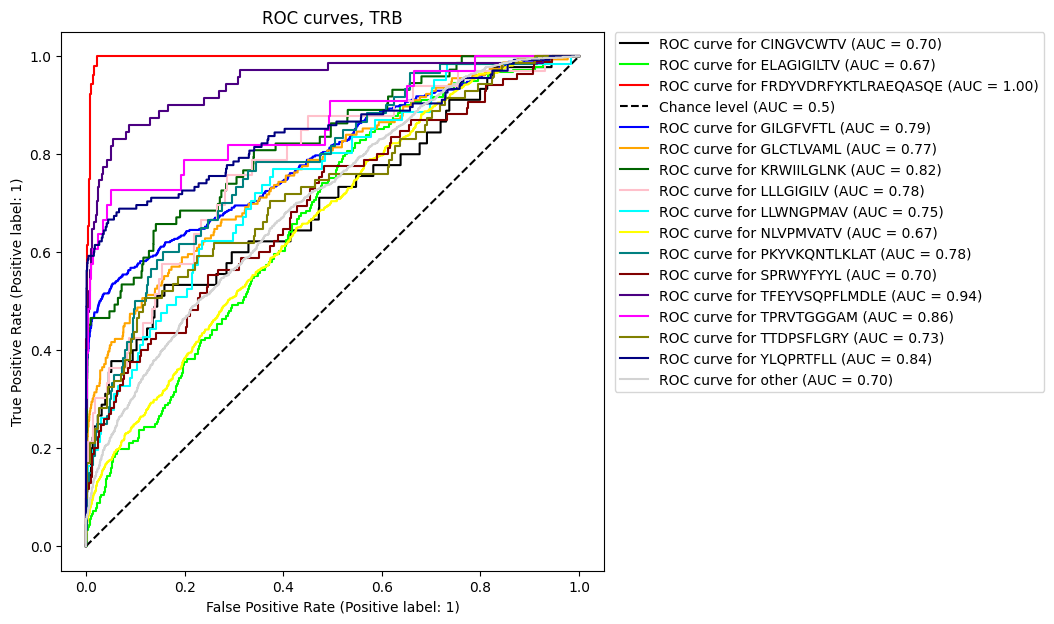

In [25]:
clf.roc_auc('TRB',custom_palette=custom_palette)

In [26]:
clf.roc_auc_proba_df['TRB'].sort_values('class')

class   roc_auc
0              CINGVCWTV  0.701852
1             ELAGIGILTV  0.668807
2   FRDYVDRFYKTLRAEQASQE  0.996087
3              GILGFVFTL  0.794946
4              GLCTLVAML  0.769175
5             KRWIILGLNK  0.822542
6              LLLGIGILV  0.784271
7              LLWNGPMAV  0.746765
8              NLVPMVATV  0.665077
9          PKYVKQNTLKLAT  0.783450
10             SPRWYFYYL  0.698371
11        TFEYVSQPFLMDLE  0.943408
12            TPRVTGGGAM  0.864283
13            TTDPSFLGRY  0.726799
14             YLQPRTFLL  0.844673
15                 other  0.703572

In [38]:
clf_all = TCRemb.TCRemb_clf('RF_all')
chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_all.clf(chain,tcremb, label, model=model,test_size=0.15)

Train accuracy: 0.9491691104594331
Test accuracy: 0.35603543743078625
macro: {'f1': 0.06173004408220069, 'precision': 0.054442683269622566, 'recall': 0.08923086537145436}
weighted: {'f1': 0.40104034502742697, 'precision': 0.5607806309734921, 'recall': 0.35603543743078625}


In [39]:

chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_all.clf(chain,tcremb, label, model=model,test_size=0.15)

Train accuracy: 0.9450919198322524
Test accuracy: 0.33812154696132596
macro: {'f1': 0.05708279882719553, 'precision': 0.04680162431193076, 'recall': 0.11403861554062761}
weighted: {'f1': 0.4014099107178122, 'precision': 0.7557508234383808, 'recall': 0.33812154696132596}


In [45]:
clf_all.clsf_metrics

{'TRA': {'train_acc': 0.9491691104594331,
  'test_acc': 0.35603543743078625,
  'f1_macro': {'f1': 0.06173004408220069,
   'precision': 0.054442683269622566,
   'recall': 0.08923086537145436},
  'f1_weighted': {'f1': 0.40104034502742697,
   'precision': 0.5607806309734921,
   'recall': 0.35603543743078625}},
 'TRB': {'train_acc': 0.9450919198322524,
  'test_acc': 0.33812154696132596,
  'f1_macro': {'f1': 0.05708279882719553,
   'precision': 0.04680162431193076,
   'recall': 0.11403861554062761},
  'f1_weighted': {'f1': 0.4014099107178122,
   'precision': 0.7557508234383808,
   'recall': 0.33812154696132596}}}

In [48]:
roc_auc_trb_all = clf_all.roc_auc_proba_df['TRB'].sort_values('class')

In [49]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [50]:
roc_auc_trb_all[roc_auc_trb_all['class'].isin(epitopes_list)]

class   roc_auc
70              CINGVCWTV  0.689056
118            ELAGIGILTV  0.636864
210  FRDYVDRFYKTLRAEQASQE  0.994598
249             GILGFVFTL  0.787949
252             GLCTLVAML  0.766211
409            KRWIILGLNK  0.783626
448             LLLGIGILV  0.698356
458             LLWNGPMAV  0.758839
580             NLVPMVATV  0.658925
606         PKYVKQNTLKLAT  0.691419
764             SPRWYFYYL  0.737063
793        TFEYVSQPFLMDLE  0.929645
827            TPRVTGGGAM  0.935178
836            TTDPSFLGRY  0.698708
957             YLQPRTFLL  0.880385

In [51]:
atm_res = [{'class': 'CINGVCWTV', 'roc_auc': 0.5752120257985882},
 {'class': 'ELAGIGILTV', 'roc_auc': 0.515489498116114},
 {'class': 'FRDYVDRFYKTLRAEQASQE', 'roc_auc': 0.677350859453994},
 {'class': 'GILGFVFTL', 'roc_auc': 0.5704231955814368},
 {'class': 'GLCTLVAML', 'roc_auc': 0.5417590286425903},
 {'class': 'KRWIILGLNK', 'roc_auc': 0.5725415070242657},
 {'class': 'LLLGIGILV', 'roc_auc': 0.5764722698684963},
 {'class': 'LLWNGPMAV', 'roc_auc': 0.5477210630899155},
 {'class': 'NLVPMVATV', 'roc_auc': 0.5250316938946034},
 {'class': 'PKYVKQNTLKLAT', 'roc_auc': 0.5584946899431166},
 {'class': 'SPRWYFYYL', 'roc_auc': 0.5273414985590779},
 {'class': 'TFEYVSQPFLMDLE', 'roc_auc': 0.730540427314621},
 {'class': 'TPRVTGGGAM', 'roc_auc': 0.6228962818003914},
 {'class': 'TTDPSFLGRY', 'roc_auc': 0.5266290726817043},
 {'class': 'YLQPRTFLL', 'roc_auc': 0.6320013101867017}]

In [52]:
atm_res = pd.DataFrame(atm_res)

In [53]:
atm_res = atm_res.rename({'roc_auc':'auc_atm_tcr'},axis=1)
roc_auc_trb_all = roc_auc_trb_all = roc_auc_trb_all.rename({'roc_auc':'auc_tcremb'},axis=1)

In [54]:
roc_auc_trb_all.merge(atm_res)

class  auc_tcremb  auc_atm_tcr
0              CINGVCWTV    0.689056     0.575212
1             ELAGIGILTV    0.636864     0.515489
2   FRDYVDRFYKTLRAEQASQE    0.994598     0.677351
3              GILGFVFTL    0.787949     0.570423
4              GLCTLVAML    0.766211     0.541759
5             KRWIILGLNK    0.783626     0.572542
6              LLLGIGILV    0.698356     0.576472
7              LLWNGPMAV    0.758839     0.547721
8              NLVPMVATV    0.658925     0.525032
9          PKYVKQNTLKLAT    0.691419     0.558495
10             SPRWYFYYL    0.737063     0.527341
11        TFEYVSQPFLMDLE    0.929645     0.730540
12            TPRVTGGGAM    0.935178     0.622896
13            TTDPSFLGRY    0.698708     0.526629
14             YLQPRTFLL    0.880385     0.632001

In [50]:
clf_500 = TCRemb.TCRemb_clf('RF_freq_500')
chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_500.clf(chain,tcremb, str(label + '_freq_500'), model=model,test_size=0.15)

Train accuracy: 0.9733137829912023
Test accuracy: 0.46511627906976744
macro: {'f1': 0.3599265081050936, 'precision': 0.3112033933016937, 'recall': 0.49928079315785256}
weighted: {'f1': 0.4984751706125958, 'precision': 0.6200784935512256, 'recall': 0.46511627906976744}


In [51]:
chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_500.clf(chain,tcremb, str(label + '_freq_500'), model=model,test_size=0.15)

Train accuracy: 0.971375627834398
Test accuracy: 0.5461325966850828
macro: {'f1': 0.280768584459444, 'precision': 0.24561790517595558, 'recall': 0.5838798872961479}
weighted: {'f1': 0.618596198316942, 'precision': 0.8077928242774112, 'recall': 0.5461325966850828}


accuracy: 0.47
f1_weighted:0.5
precision:0.62
recall:0.47


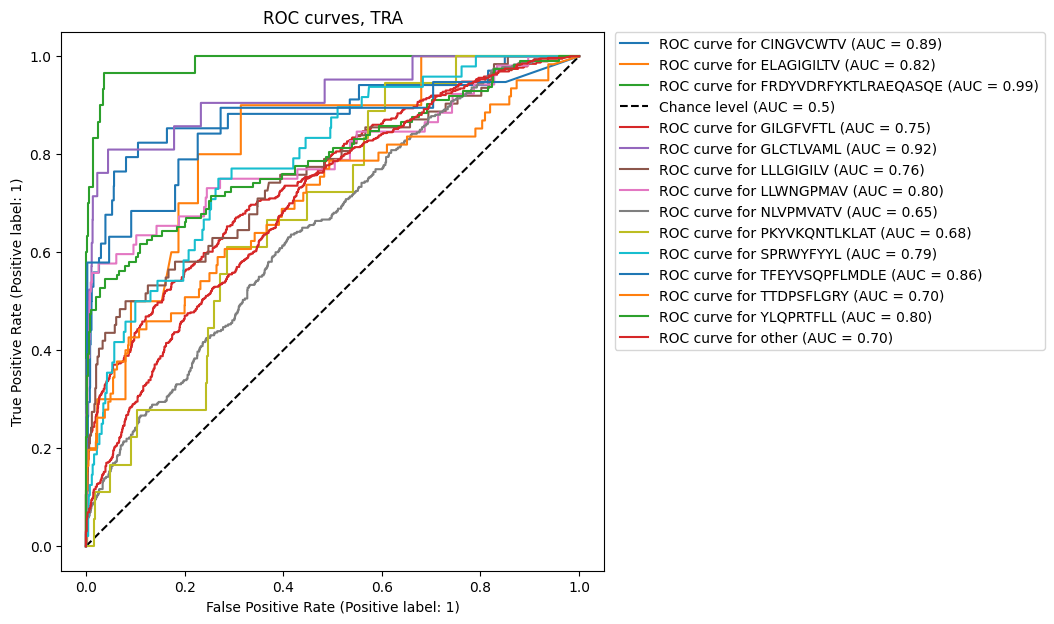

In [52]:
clf_500.roc_auc('TRA')

In [62]:
clf_500.roc_auc_proba_df['TRB'].sort_values('roc_auc')

class   roc_auc
1             ELAGIGILTV  0.644633
7              NLVPMVATV  0.689330
5              LLLGIGILV  0.707848
13                 other  0.710905
8          PKYVKQNTLKLAT  0.730024
6              LLWNGPMAV  0.738687
11            TTDPSFLGRY  0.759453
4              GLCTLVAML  0.760921
0              CINGVCWTV  0.785924
3              GILGFVFTL  0.803595
9              SPRWYFYYL  0.821387
12             YLQPRTFLL  0.891288
10        TFEYVSQPFLMDLE  0.893684
2   FRDYVDRFYKTLRAEQASQE  0.972792

accuracy: 0.55
f1_weighted:0.62
precision:0.81
recall:0.55


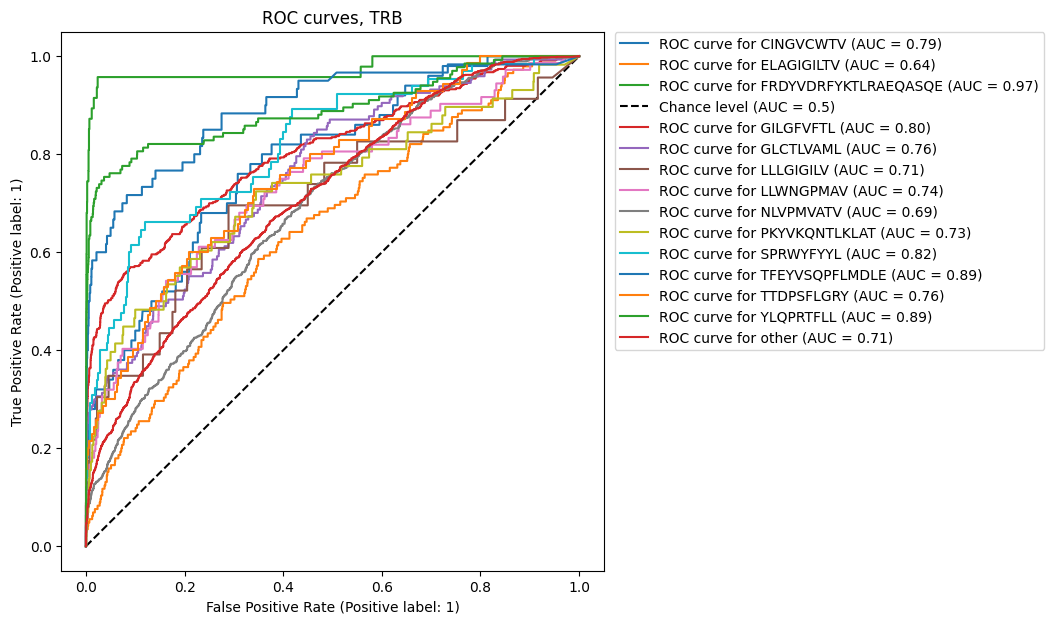

In [53]:
clf_500.roc_auc('TRB')

In [63]:
clf_100 = TCRemb.TCRemb_clf('RF_freq_100')
chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_100.clf(chain,tcremb, str(label + '_freq_100'), model=model,test_size=0.15)

Train accuracy: 0.9724340175953079
Test accuracy: 0.3853820598006645
macro: {'f1': 0.20265623372366806, 'precision': 0.16712937783072584, 'recall': 0.3195903583343941}
weighted: {'f1': 0.4038929796708792, 'precision': 0.45648099678254717, 'recall': 0.3853820598006645}


In [64]:

chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf_100.clf(chain,tcremb, str(label + '_freq_100'), model=model,test_size=0.15)

Train accuracy: 0.9795679524064953
Test accuracy: 0.37596685082872927
macro: {'f1': 0.18172206575985597, 'precision': 0.14331505043970866, 'recall': 0.48213104413470853}
weighted: {'f1': 0.41405696847319207, 'precision': 0.5499677197958581, 'recall': 0.37596685082872927}


accuracy: 0.39
f1_weighted:0.4
precision:0.46
recall:0.39


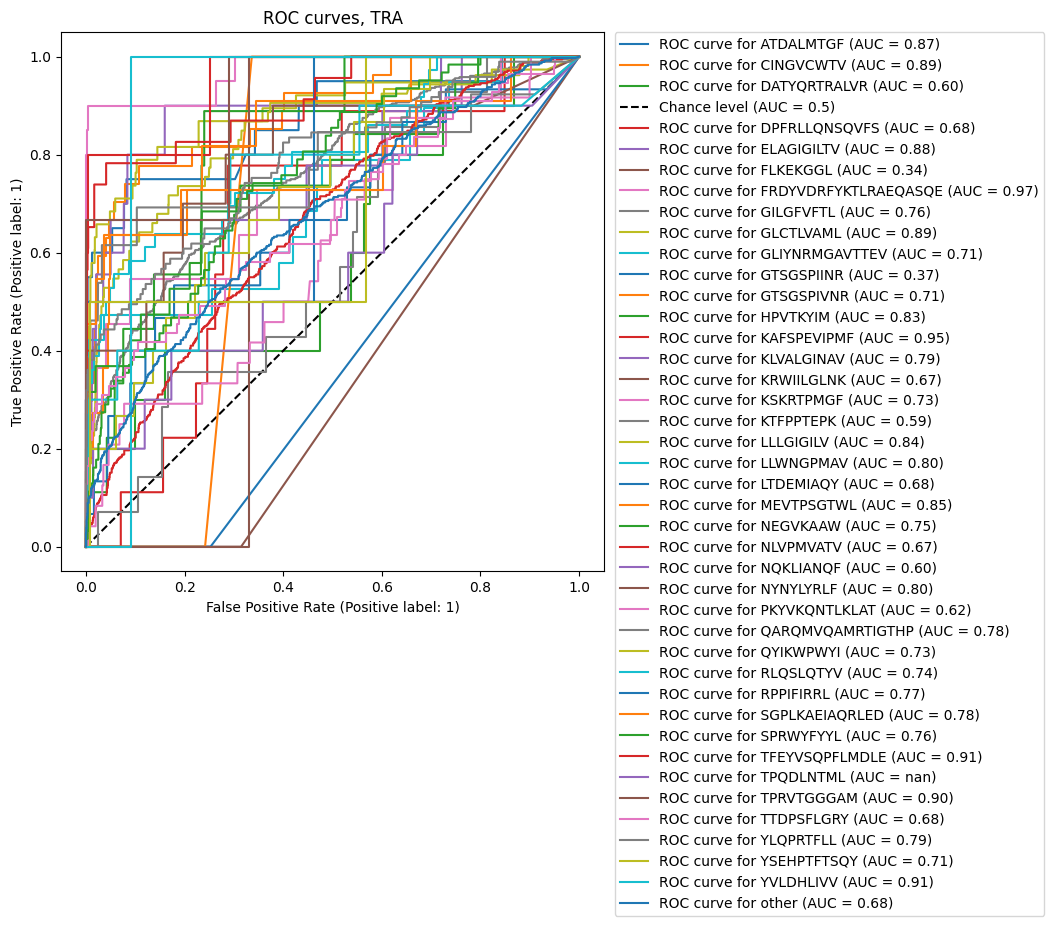

In [65]:
clf_100.roc_auc('TRA')

accuracy: 0.38
f1_weighted:0.41
precision:0.55
recall:0.38


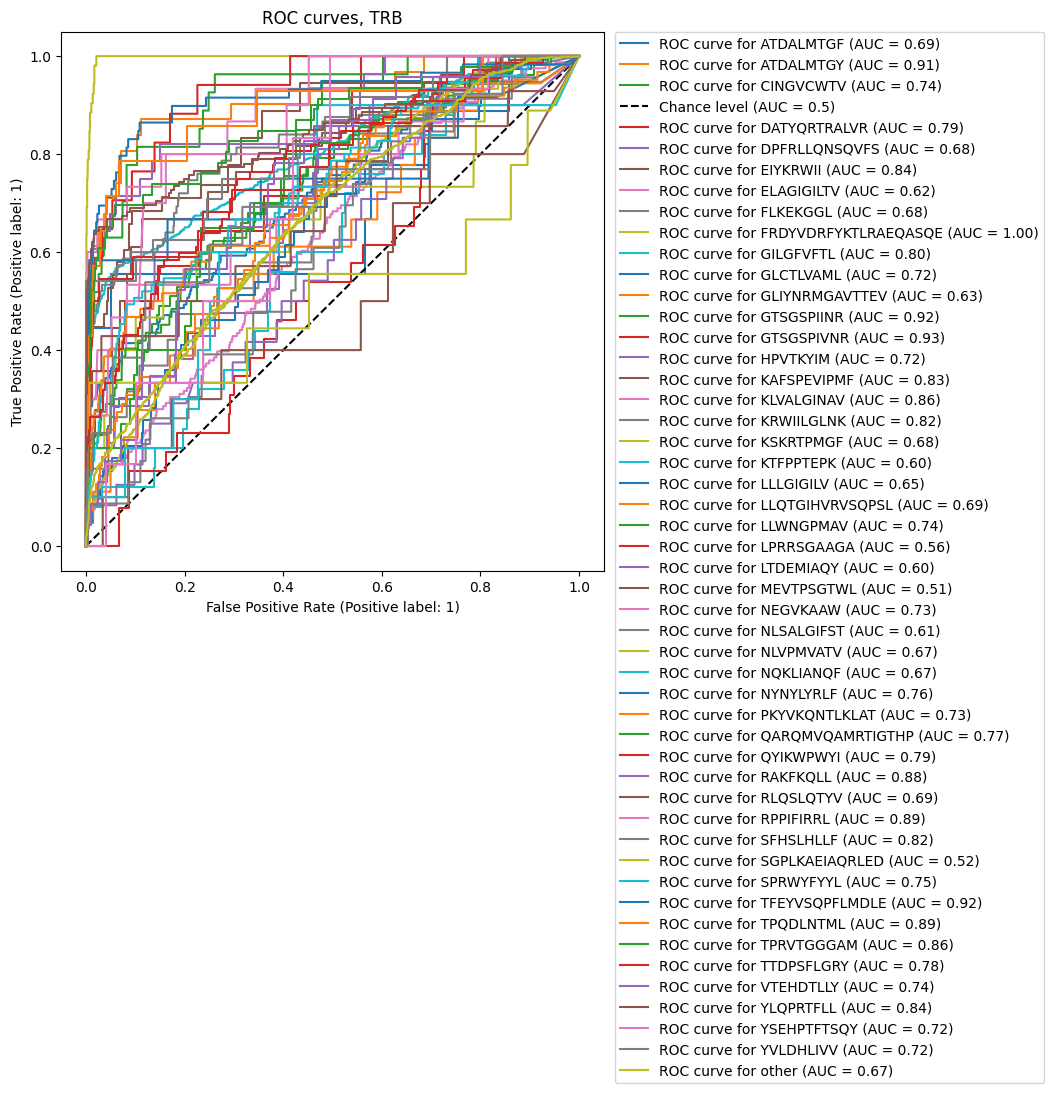

In [66]:
clf_100.roc_auc('TRB')

In [ ]:
clf = TCRemb.TCRemb_clf_bind('test')
chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb, label,model=model,labels_list = ['GILGFVFTL','YLQPRTFLL','GLCTLVAML','NLVPMVATV'],test_size=0.15)

In [ ]:
from sklearn.model_selection import cross_val_score



In [ ]:
def clf_model(model, label_np, proc_df, annotation_id_column, chain, test_size = 0.3 ,show_legend=True, ax=None):
    
    y_train, y_test,X_train, X_test,  = train_test_split(label_np, proc_df.drop(annotation_id_column, axis=1, errors = 'ignore') ,test_size=test_size)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)   
    print(f'Train accuracy: {model.score(X_train,y_train)}')
    print(f'Test accuracy: {model.score(X_test,y_test)}')
    print(f"macro: {TCRemb_code2.clsf_metrics(pred,y_test,'macro')}")
    print(f"weighted: {TCRemb_code2.clsf_metrics(pred,y_test,'weighted')}")
    
    print(f'cross_val_score: {cross_val_score(model, proc_df.drop(annotation_id_column, axis=1, errors = "ignore"), label_np, cv=5, scoring="accuracy")}')
    print(f'cross_val_score f1_weighted: {cross_val_score(model, proc_df.drop(annotation_id_column, axis=1, errors = "ignore"), label_np, cv=5, scoring="f1_weighted")}')
    
    
    roc_auc_df = TCRemb_code2.roc_auc(model, pred, y_test, X_test, chain, show_legend, ax)
    
    return model, roc_auc_df.sort_values('roc_auc',ascending=False)

In [ ]:
clsf_dict = {}

In [ ]:
model_name = 'RF_label_20'
label_cl = label+'_freq_20'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_100'
label_cl = label+'_freq_100'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,show_legend=False)


In [ ]:
model_name = 'RF_label_200'
label_cl = label+'_freq_200'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_300'
label_cl = label+'_freq_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain,show_legend=False)


In [ ]:
model_name = 'RF_label_500'
label_cl = label+'_freq_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_1000'
label_cl = label+'_freq_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain) ##TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain) ##TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_high'
label_cl = label_high
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_high_s'
label_cl = label_high_s
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


### SVM

In [ ]:
model_name = 'SVM_label_high'
label_cl = label_high
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
from sklearn.svm import SVC

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain],y_train, y_test,X_train, X_test = TCRemb_code2.clf_model_tt(model,y_data, X_data , annotation_id, chain, test_size = 0.15)


In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain],y_train, y_test,X_train, X_test = TCRemb_code2.clf_model_tt(model,y_data, X_data , annotation_id, chain, test_size = 0.15)


In [ ]:
model_name = 'SVM_label_300'
label_cl = label+'_freq_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
model_name = 'SVM_label_500'
label_cl = label+'_freq_500'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_label_1000'
label_cl = label+'_freq_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_label_high_s'
label_cl = label_high_s
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_ovr'
label_cl = label
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = OneVsRestClassifier(SVC())
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)

In [ ]:
pd.DataFrame(clsf_dict[model_name]['roc_auc'][chain]).head(30)

In [ ]:
## with label_high
chain = 'TRB'
model_name = 'SVC_ovr'
clsf_dict[model_name]= {'model':{}, 'roc_auc':{}}

clf_rf_model = OneVsRestClassifier(SVC())
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code.clf_model(clf_rf_model,pca_res_annot_dict[chain][label_high], pca_res_dict[chain] , annotation_id_column_dict[chain], 0.3)


In [ ]:
pd.DataFrame(clsf_dict[model_name]['roc_auc'][chain]).head(30)

In [39]:
!pwd

/home/ykremlyakova/projects/tcr_emb_mirpy_old


## Fig

In [57]:
t

antigen.epitope_high_count_1000   cdr3
0                      ELAGIGILTV   1159
1                       GILGFVFTL   5574
2                       GLCTLVAML   1140
3                       NLVPMVATV   7059
4                       YLQPRTFLL   1566
5                           other  19695

([<matplotlib.patches.Wedge at 0x7fda456f6ed0>,
 [Text(1.0944382197910936, 0.11047616512398618, 'ELAGIGILTV'),
  Text(0.851837011373225, 0.6959696157554095, 'GILGFVFTL'),
  Text(0.3282015748821189, 1.0498970074463958, 'GLCTLVAML'),
  Text(-0.4371614909693769, 1.0094007285580051, 'NLVPMVATV'),
  Text(-1.0073213862028194, 0.4419316970963164, 'YLQPRTFLL'),
  Text(-0.15213737562761476, -1.0894283909175226, 'other')])

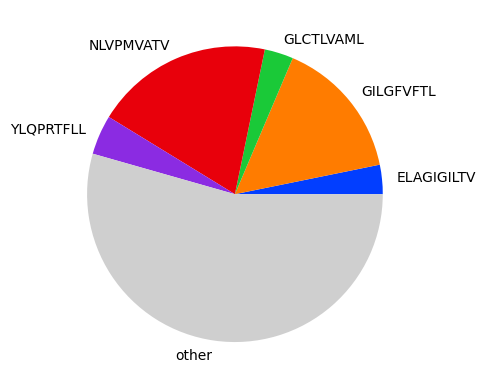

In [63]:
t = pd.DataFrame(data_preped.groupby(str(label+'_freq_1000'))['cdr3aa'].count().reset_index())
custom_palette = ml_utils.make_custom_palette(label_freq_dict[str(label+'_freq_1000')])
plt.pie(t['cdr3aa'],labels=t['antigen.epitope_freq_1000'],colors=custom_palette.values())

In [ ]:
fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_freq_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_freq_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)



clf.roc_auc('TRA',ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


clf.roc_auc('TRB',ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

plt.show()

In [ ]:
clf.roc_auc('TRB',custom_palette=custom_palette)

accuracy: 0.43
f1_weighted:0.47
precision:0.58
recall:0.43
accuracy: 0.5
f1_weighted:0.58
precision:0.8
recall:0.5


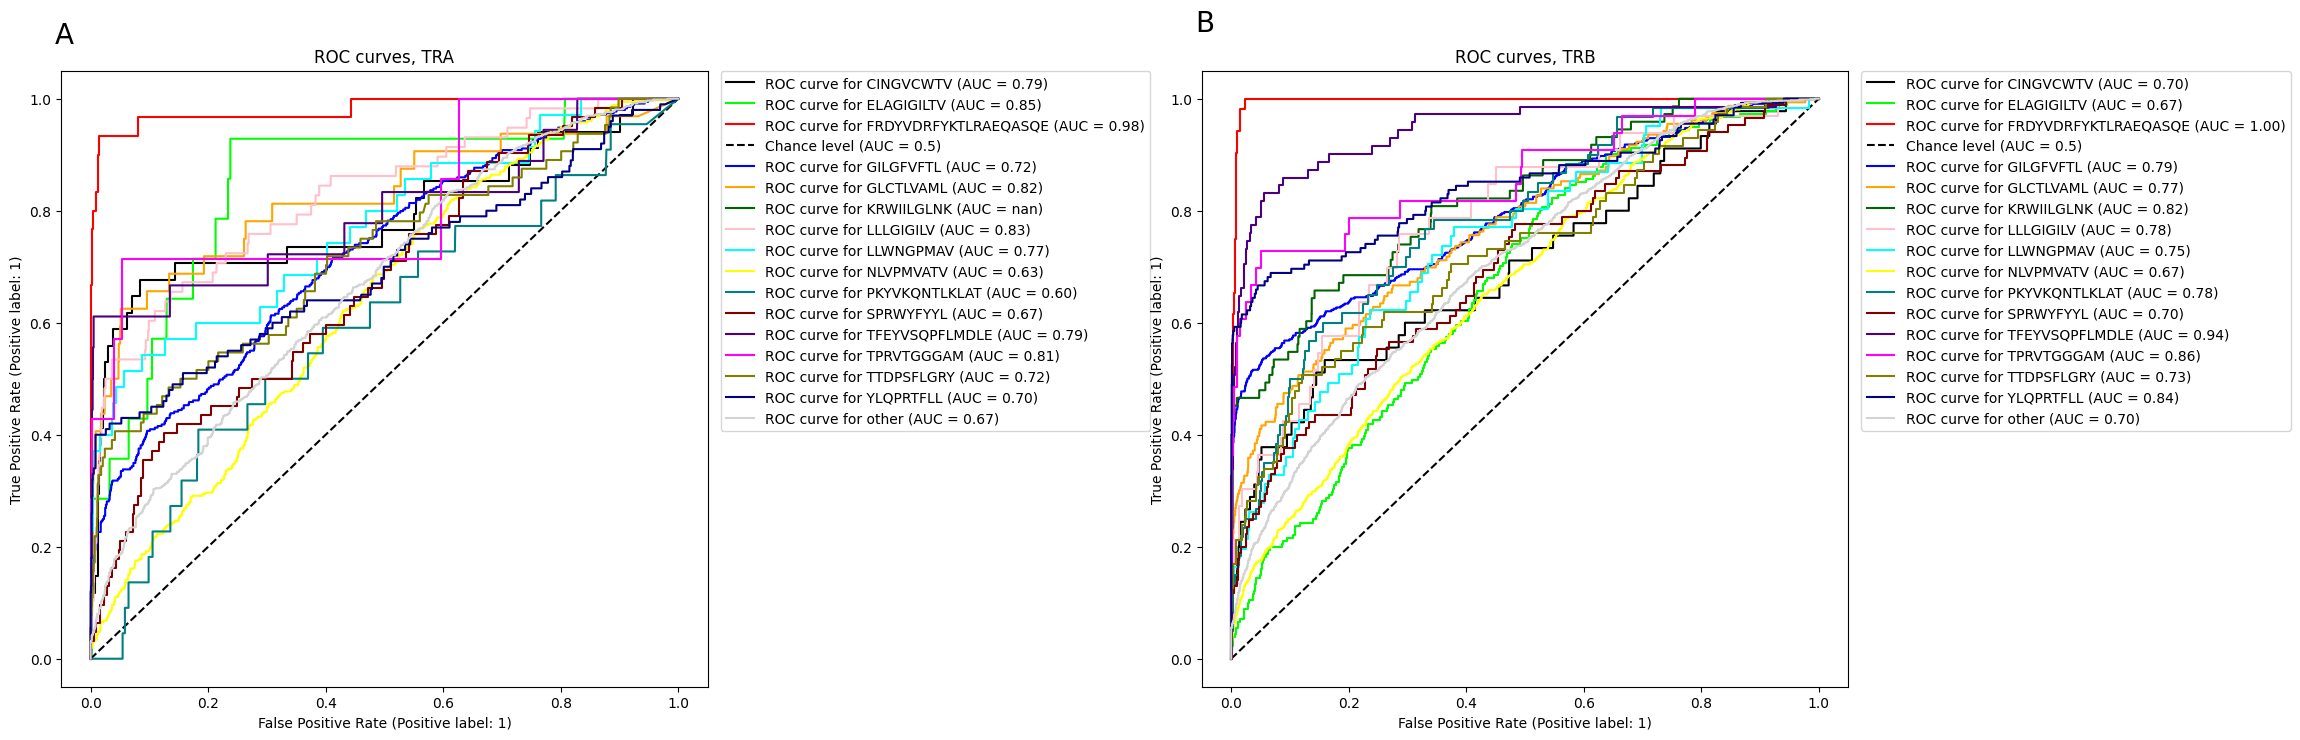

In [50]:



fig = plt.figure(figsize=(26,8))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(1, 9)

ax1 = fig.add_subplot(gs00[:3])
ax2 = fig.add_subplot(gs00[5:8])



clf.roc_auc('TRA',custom_palette=custom_palette, ax=ax1)

ax1.text(delta_x, delta_y - 0.02, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
#ax1.set_title('tcr counts for each epitope')

clf.roc_auc('TRB',custom_palette=custom_palette, ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
#ax2.set_title('top count epitopes')


plt.savefig("results/figures/fig6.png")
plt.show()





In [ ]:

fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_freq_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_freq_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label+'_freq_1000'
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


chain = 'TRB'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

plt.savefig("results/figures/fig2.png")
plt.show()





In [ ]:

fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_freq_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_freq_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_freq_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label+'_freq_1000'
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


chain = 'TRB'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


#plt.savefig("tcremb_outputs/figures/fig2.svg")
#plt.savefig("tcremb_outputs/figures/fig2.pdf")
#plt.savefig("tcremb_outputs/figures/fig2.png")
plt.show()





In [ ]:
label_high_s_1000

In [ ]:

max_depth = 100
fig = plt.figure(figsize=(20,22))

delta_x=-0.01
delta_y=1.1
font_size=20

gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])

sns.histplot(data = data_preped, y = 'antigen.species',hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each species')

sns.histplot(data = data_preped, y = label_high_s_1000,hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count species')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000),f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax3)

ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000), f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label_high_s_1000
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

chain = 'TRB'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


plt.savefig("results/figures/fig2.2.png")
plt.show()

In [ ]:

fig = plt.figure(figsize=(20,22))

delta_x=-0.01
delta_y=1.1
font_size=20

gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])

sns.histplot(data = data_preped, y = 'antigen.species',hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each species')

sns.histplot(data = data_preped, y = label_high_s_1000,hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count species')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000),f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax3)

ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000), f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label_high_s_1000
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
c=5


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

chain = 'TRB'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


plt.savefig("results/figures/fig2.2.png")
plt.show()

In [ ]:
chain = 'TRA'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_freq_1000'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_freq_1000")}')

In [ ]:
chain = 'TRB'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_freq_1000'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_freq_1000")}')

In [ ]:
chain = 'TRB'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_freq_200'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_freq_200")}')

In [ ]:
model_name = 'RF_label_1000'
label_cl = label+'_freq_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)

chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
label_cl = label
model_name = 'KMeans'
threshold = 0.6
clstr_dict[model_name]= {'binom_res':{},'clstr_metrics':{},'binom_res_train':{},'clstr_metrics_train':{}}
tcremb['clstr_labels'][model_name]={}




chain = 'TRA'
n_clusters = 5295
random_state = 8

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]#.drop(annotation_id, axis=1, errors = 'ignore')

model =  KMeans(n_clusters=n_clusters, random_state=random_state)
tcremb['clstr_labels'][model_name][chain] = TCRemb_code2.clstr_model(model, X_data , annotation_id)

clstr_dict[model_name]['binom_res'][chain] = TCRemb_code2.binominal_test(pd.merge(tcremb['clstr_labels'][model_name][chain],tcremb['annot'][chain]), 'cluster', label_cl)
clstr_dict[model_name]['binom_res'][chain]['enriched_clstr'] =clstr_dict[model_name]['binom_res'][chain].apply(lambda x:1 
                                                                                                               if (x.fraction_matched>=threshold)
                                                                                                               and (x.total_cluster>2) else 0,axis=1)
clstr_dict[model_name]['clstr_metrics'][chain] = TCRemb_code2.clstr_metrics(tcremb['annot'][chain][label_cl],tcremb['clstr_labels'][model_name][chain]['cluster'])



tcremb['clstr_labels'][model_name][chain] = tcremb['clstr_labels'][model_name][chain].merge(clstr_dict[model_name]['binom_res'][chain].rename({label_cl:'label_cluster'},axis=1)
                                                                                            , on='cluster',how='left').sort_values(annotation_id).reset_index(drop=True)

print('mean fraction_matched: ' + str(statistics.mean(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print('median fraction_matched: ' + str(statistics.median(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print(clstr_dict[model_name]['clstr_metrics'][chain])


sns.histplot(tcremb['clstr_labels'][model_name][chain]['enriched_clstr'].astype(str))
plt.title('count of tcrs in enriched clusters')
TCRemb_code2.tsne_plot(pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id), 'enriched_clstr', f'10x ,{chain}', f'TSNE colored by enriched_clstr', True)

chain = 'TRB'
n_clusters = 10616
random_state = 8

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]#.drop(annotation_id, axis=1, errors = 'ignore')

model =  KMeans(n_clusters=n_clusters, random_state=random_state)
tcremb['clstr_labels'][model_name][chain] = TCRemb_code2.clstr_model(model, X_data , annotation_id)

clstr_dict[model_name]['binom_res'][chain] = TCRemb_code2.binominal_test(pd.merge(tcremb['clstr_labels'][model_name][chain],tcremb['annot'][chain]), 'cluster', label_cl)
clstr_dict[model_name]['binom_res'][chain]['enriched_clstr'] =clstr_dict[model_name]['binom_res'][chain].apply(lambda x:1 
                                                                                                               if (x.fraction_matched>=threshold)
                                                                                                               and (x.total_cluster>2) else 0,axis=1)
clstr_dict[model_name]['clstr_metrics'][chain] = TCRemb_code2.clstr_metrics(tcremb['annot'][chain][label_cl],tcremb['clstr_labels'][model_name][chain]['cluster'])



tcremb['clstr_labels'][model_name][chain] = tcremb['clstr_labels'][model_name][chain].merge(clstr_dict[model_name]['binom_res'][chain].rename({label_cl:'label_cluster'},axis=1)
                                                                                            , on='cluster',how='left').sort_values(annotation_id).reset_index(drop=True)

print('mean fraction_matched: ' + str(statistics.mean(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print('median fraction_matched: ' + str(statistics.median(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print(clstr_dict[model_name]['clstr_metrics'][chain])


sns.histplot(tcremb['clstr_labels'][model_name][chain]['enriched_clstr'].astype(str))
plt.title('count of tcrs in enriched clusters')
TCRemb_code2.tsne_plot(pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id), 'enriched_clstr', f'10x ,{chain}', f'TSNE colored by enriched_clstr', True)
